In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N32_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 25
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 32


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/Jackpot/experiments/measure_3D/N32_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 640_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 9.30981159210205 sec.


  0%|                                                                                                  | 0/800 [00:00<?, ?it/s]

  2%|██                                                                                       | 18/800 [00:24<17:35,  1.35s/it]

  5%|████▏                                                                                    | 38/800 [00:24<06:40,  1.90it/s]

  7%|██████▍                                                                                  | 58/800 [00:24<03:30,  3.52it/s]

 11%|█████████▊                                                                               | 88/800 [00:39<03:22,  3.52it/s]

 12%|██████████▉                                                                              | 98/800 [00:48<05:25,  2.16it/s]

 14%|███████████▉                                                                            | 108/800 [00:48<04:31,  2.55it/s]

 15%|████████████▉                                                                           | 118/800 [00:49<03:39,  3.10it/s]

 17%|███████████████▏                                                                        | 138/800 [00:49<02:19,  4.73it/s]

 20%|█████████████████▍                                                                      | 158/800 [00:49<01:34,  6.83it/s]

 21%|██████████████████▍                                                                     | 168/800 [00:50<01:18,  8.02it/s]

 21%|██████████████████▍                                                                     | 168/800 [01:10<01:18,  8.02it/s]

 22%|███████████████████▌                                                                    | 178/800 [01:13<06:10,  1.68it/s]

 24%|████████████████████▋                                                                   | 188/800 [01:13<04:48,  2.12it/s]

 25%|█████████████████████▊                                                                  | 198/800 [01:14<03:35,  2.79it/s]

 26%|██████████████████████▉                                                                 | 208/800 [01:14<02:38,  3.73it/s]

 28%|█████████████████████████                                                               | 228/800 [01:14<01:31,  6.23it/s]

 31%|███████████████████████████▎                                                            | 248/800 [01:15<01:00,  9.07it/s]

 31%|███████████████████████████▎                                                            | 248/800 [01:30<01:00,  9.07it/s]

 32%|████████████████████████████▍                                                           | 258/800 [01:37<05:01,  1.80it/s]

 34%|█████████████████████████████▍                                                          | 268/800 [01:38<04:03,  2.19it/s]

 35%|██████████████████████████████▌                                                         | 278/800 [01:38<03:01,  2.88it/s]

 36%|███████████████████████████████▋                                                        | 288/800 [01:38<02:12,  3.86it/s]

 37%|████████████████████████████████▊                                                       | 298/800 [01:39<01:39,  5.03it/s]

 38%|█████████████████████████████████▉                                                      | 308/800 [01:39<01:13,  6.72it/s]

 40%|██████████████████████████████████▉                                                     | 318/800 [01:39<00:53,  9.01it/s]

 41%|████████████████████████████████████                                                    | 328/800 [01:39<00:40, 11.78it/s]

 41%|████████████████████████████████████                                                    | 328/800 [01:50<00:40, 11.78it/s]

 42%|█████████████████████████████████████▏                                                  | 338/800 [02:02<05:28,  1.41it/s]

 44%|██████████████████████████████████████▎                                                 | 348/800 [02:02<03:58,  1.90it/s]

 45%|███████████████████████████████████████▍                                                | 358/800 [02:03<02:48,  2.62it/s]

 46%|████████████████████████████████████████▍                                               | 368/800 [02:03<02:03,  3.49it/s]

 47%|█████████████████████████████████████████▌                                              | 378/800 [02:04<01:26,  4.88it/s]

 48%|██████████████████████████████████████████▋                                             | 388/800 [02:04<01:05,  6.30it/s]

 50%|███████████████████████████████████████████▊                                            | 398/800 [02:04<00:49,  8.19it/s]

 51%|████████████████████████████████████████████▉                                           | 408/800 [02:20<00:47,  8.19it/s]

 52%|█████████████████████████████████████████████▉                                          | 418/800 [02:25<03:27,  1.84it/s]

 54%|███████████████████████████████████████████████                                         | 428/800 [02:26<02:44,  2.27it/s]

 55%|████████████████████████████████████████████████▏                                       | 438/800 [02:27<02:02,  2.95it/s]

 56%|█████████████████████████████████████████████████▎                                      | 448/800 [02:28<01:36,  3.64it/s]

 57%|██████████████████████████████████████████████████▍                                     | 458/800 [02:28<01:12,  4.73it/s]

 58%|███████████████████████████████████████████████████▍                                    | 468/800 [02:29<00:52,  6.35it/s]

 60%|████████████████████████████████████████████████████▌                                   | 478/800 [02:29<00:40,  7.98it/s]

 61%|█████████████████████████████████████████████████████▋                                  | 488/800 [02:30<00:32,  9.50it/s]

 62%|██████████████████████████████████████████████████████▊                                 | 498/800 [02:49<03:17,  1.53it/s]

 64%|███████████████████████████████████████████████████████▉                                | 508/800 [02:51<02:30,  1.94it/s]

 65%|████████████████████████████████████████████████████████▉                               | 518/800 [02:52<01:45,  2.68it/s]

 66%|██████████████████████████████████████████████████████████                              | 528/800 [02:53<01:19,  3.40it/s]

 67%|███████████████████████████████████████████████████████████▏                            | 538/800 [02:53<00:56,  4.61it/s]

 68%|████████████████████████████████████████████████████████████▎                           | 548/800 [02:54<00:42,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████▍                         | 568/800 [02:54<00:25,  9.09it/s]

 71%|██████████████████████████████████████████████████████████████▍                         | 568/800 [03:10<00:25,  9.09it/s]

 72%|███████████████████████████████████████████████████████████████▌                        | 578/800 [03:13<02:02,  1.82it/s]

 74%|████████████████████████████████████████████████████████████████▋                       | 588/800 [03:15<01:38,  2.15it/s]

 76%|██████████████████████████████████████████████████████████████████▉                     | 608/800 [03:17<00:58,  3.29it/s]

 77%|███████████████████████████████████████████████████████████████████▉                    | 618/800 [03:18<00:43,  4.16it/s]

 78%|█████████████████████████████████████████████████████████████████████                   | 628/800 [03:19<00:35,  4.90it/s]

 81%|███████████████████████████████████████████████████████████████████████▎                | 648/800 [03:19<00:19,  7.98it/s]

 81%|███████████████████████████████████████████████████████████████████████▎                | 648/800 [03:30<00:19,  7.98it/s]

 82%|████████████████████████████████████████████████████████████████████████▍               | 658/800 [03:37<01:14,  1.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████▎              | 667/800 [03:40<01:01,  2.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████▍             | 677/800 [03:40<00:42,  2.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████▌            | 687/800 [03:40<00:29,  3.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████▋           | 697/800 [03:42<00:24,  4.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████▊         | 716/800 [03:42<00:11,  7.07it/s]

 91%|███████████████████████████████████████████████████████████████████████████████▊        | 725/800 [03:43<00:08,  8.51it/s]

 92%|████████████████████████████████████████████████████████████████████████████████▊       | 735/800 [03:43<00:06,  9.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████▉      | 745/800 [03:44<00:04, 12.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████    | 764/800 [03:45<00:02, 15.05it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████   | 773/800 [03:45<00:01, 15.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████  | 782/800 [03:46<00:01, 14.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████ | 791/800 [03:46<00:00, 16.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:46<00:00, 20.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:00<00:00, 20.82it/s]

Ran thermalisation program in: 249.23548245429993 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 4.011568654488547 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

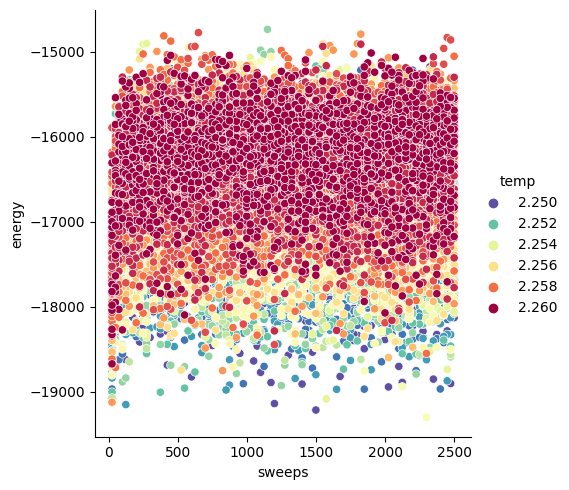

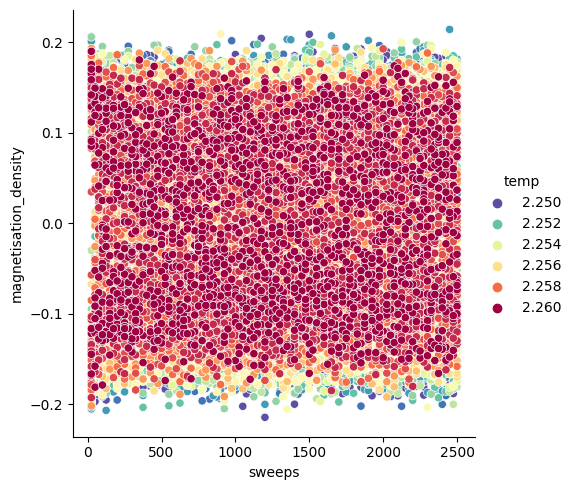

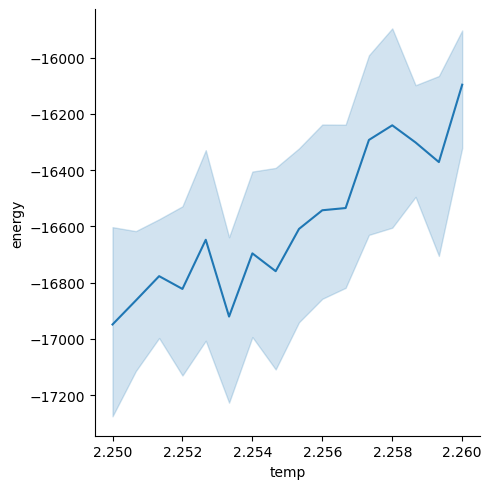

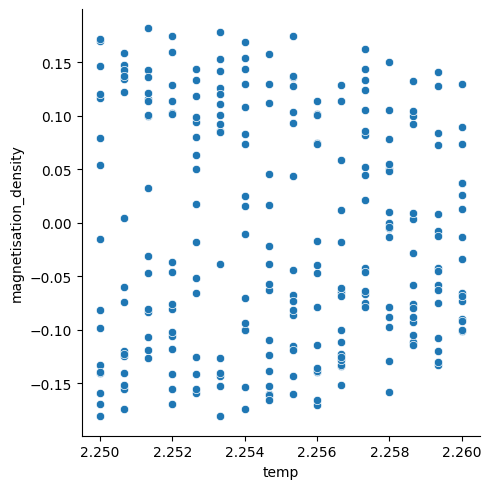

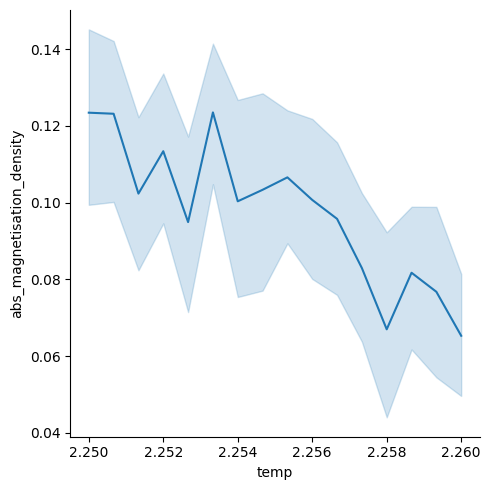

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

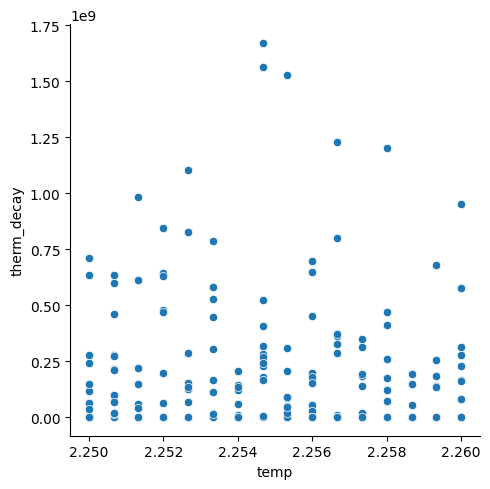

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        250,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                 | 0/8000 [00:00<?, ?it/s]

  0%|▏                                                                                       | 12/8000 [00:03<42:22,  3.14it/s]

  0%|▏                                                                                       | 20/8000 [00:03<22:45,  5.84it/s]

  0%|▎                                                                                       | 28/8000 [00:04<14:28,  9.18it/s]

  1%|▍                                                                                       | 44/8000 [00:07<22:45,  5.82it/s]

  1%|▌                                                                                       | 52/8000 [00:07<16:59,  7.80it/s]

  1%|▋                                                                                       | 60/8000 [00:08<12:59, 10.19it/s]

  1%|▋                                                                                       | 68/8000 [00:08<09:54, 13.34it/s]

  1%|▊                                                                                       | 76/8000 [00:11<23:50,  5.54it/s]

  1%|▉                                                                                       | 80/8000 [00:11<20:22,  6.48it/s]

  1%|█                                                                                       | 96/8000 [00:12<11:14, 11.72it/s]

  1%|█▏                                                                                     | 104/8000 [00:12<09:01, 14.58it/s]

  1%|█▏                                                                                     | 112/8000 [00:15<21:44,  6.05it/s]

  1%|█▎                                                                                     | 116/8000 [00:15<18:54,  6.95it/s]

  2%|█▎                                                                                     | 120/8000 [00:15<16:15,  8.07it/s]

  2%|█▎                                                                                     | 124/8000 [00:15<13:37,  9.64it/s]

  2%|█▍                                                                                     | 128/8000 [00:16<11:18, 11.60it/s]

  2%|█▍                                                                                     | 136/8000 [00:16<08:01, 16.35it/s]

  2%|█▌                                                                                     | 140/8000 [00:19<28:46,  4.55it/s]

  2%|█▌                                                                                     | 144/8000 [00:19<24:41,  5.30it/s]

  2%|█▋                                                                                     | 156/8000 [00:20<13:45,  9.51it/s]

  2%|█▋                                                                                     | 160/8000 [00:20<11:51, 11.02it/s]

  2%|█▊                                                                                     | 168/8000 [00:20<09:39, 13.50it/s]

  2%|█▊                                                                                     | 172/8000 [00:23<26:42,  4.89it/s]

  2%|█▉                                                                                     | 176/8000 [00:23<22:57,  5.68it/s]

  2%|█▉                                                                                     | 180/8000 [00:23<18:10,  7.17it/s]

  2%|██                                                                                     | 184/8000 [00:23<14:48,  8.80it/s]

  2%|██                                                                                     | 188/8000 [00:24<12:57, 10.04it/s]

  2%|██▏                                                                                    | 200/8000 [00:24<06:50, 19.01it/s]

  3%|██▎                                                                                    | 208/8000 [00:27<22:36,  5.74it/s]

  3%|██▎                                                                                    | 216/8000 [00:27<15:56,  8.13it/s]

  3%|██▍                                                                                    | 220/8000 [00:28<15:00,  8.63it/s]

  3%|██▍                                                                                    | 224/8000 [00:28<13:04,  9.92it/s]

  3%|██▌                                                                                    | 236/8000 [00:30<20:30,  6.31it/s]

  3%|██▌                                                                                    | 240/8000 [00:31<20:23,  6.34it/s]

  3%|██▋                                                                                    | 248/8000 [00:31<14:49,  8.72it/s]

  3%|██▋                                                                                    | 252/8000 [00:32<13:51,  9.32it/s]

  3%|██▊                                                                                    | 260/8000 [00:32<09:52, 13.06it/s]

  3%|██▊                                                                                    | 264/8000 [00:32<09:28, 13.60it/s]

  3%|██▉                                                                                    | 268/8000 [00:34<22:52,  5.63it/s]

  3%|██▉                                                                                    | 272/8000 [00:35<22:28,  5.73it/s]

  3%|███                                                                                    | 276/8000 [00:35<17:33,  7.33it/s]

  4%|███                                                                                    | 280/8000 [00:35<14:04,  9.14it/s]

  4%|███                                                                                    | 284/8000 [00:36<14:57,  8.59it/s]

  4%|███▏                                                                                   | 288/8000 [00:36<12:13, 10.52it/s]

  4%|███▏                                                                                   | 292/8000 [00:36<09:49, 13.08it/s]

  4%|███▏                                                                                   | 296/8000 [00:36<09:50, 13.04it/s]

  4%|███▎                                                                                   | 300/8000 [00:38<23:43,  5.41it/s]

  4%|███▎                                                                                   | 304/8000 [00:39<24:04,  5.33it/s]

  4%|███▎                                                                                   | 308/8000 [00:39<18:13,  7.04it/s]

  4%|███▍                                                                                   | 316/8000 [00:40<14:21,  8.92it/s]

  4%|███▍                                                                                   | 320/8000 [00:40<12:08, 10.54it/s]

  4%|███▌                                                                                   | 324/8000 [00:40<10:34, 12.09it/s]

  4%|███▌                                                                                   | 328/8000 [00:40<10:01, 12.76it/s]

  4%|███▌                                                                                   | 332/8000 [00:42<21:40,  5.90it/s]

  4%|███▋                                                                                   | 336/8000 [00:43<23:16,  5.49it/s]

  4%|███▋                                                                                   | 340/8000 [00:43<17:48,  7.17it/s]

  4%|███▋                                                                                   | 344/8000 [00:43<14:04,  9.07it/s]

  4%|███▊                                                                                   | 348/8000 [00:44<15:27,  8.25it/s]

  4%|███▊                                                                                   | 352/8000 [00:44<12:57,  9.84it/s]

  4%|███▊                                                                                   | 356/8000 [00:44<10:47, 11.81it/s]

  4%|███▉                                                                                   | 360/8000 [00:44<09:42, 13.12it/s]

  5%|███▉                                                                                   | 364/8000 [00:46<20:28,  6.22it/s]

  5%|████                                                                                   | 368/8000 [00:47<24:17,  5.24it/s]

  5%|████                                                                                   | 376/8000 [00:47<14:58,  8.49it/s]

  5%|████▏                                                                                  | 380/8000 [00:47<15:48,  8.03it/s]

  5%|████▏                                                                                  | 384/8000 [00:48<14:44,  8.61it/s]

  5%|████▎                                                                                  | 392/8000 [00:48<10:39, 11.90it/s]

  5%|████▎                                                                                  | 396/8000 [00:49<17:30,  7.24it/s]

  5%|████▎                                                                                  | 400/8000 [00:50<21:15,  5.96it/s]

  5%|████▍                                                                                  | 404/8000 [00:51<17:44,  7.14it/s]

  5%|████▍                                                                                  | 412/8000 [00:52<15:45,  8.02it/s]

  5%|████▌                                                                                  | 416/8000 [00:52<15:08,  8.35it/s]

  5%|████▌                                                                                  | 424/8000 [00:52<09:46, 12.92it/s]

  5%|████▋                                                                                  | 428/8000 [00:53<17:23,  7.25it/s]

  5%|████▋                                                                                  | 432/8000 [00:54<19:22,  6.51it/s]

  5%|████▋                                                                                  | 436/8000 [00:55<18:13,  6.91it/s]

  6%|████▊                                                                                  | 444/8000 [00:56<16:15,  7.75it/s]

  6%|████▊                                                                                  | 448/8000 [00:56<15:02,  8.37it/s]

  6%|████▉                                                                                  | 452/8000 [00:56<12:21, 10.18it/s]

  6%|████▉                                                                                  | 456/8000 [00:56<10:12, 12.31it/s]

  6%|█████                                                                                  | 460/8000 [00:57<14:16,  8.80it/s]

  6%|█████                                                                                  | 464/8000 [00:58<20:40,  6.07it/s]

  6%|█████                                                                                  | 468/8000 [00:59<18:07,  6.92it/s]

  6%|█████▏                                                                                 | 476/8000 [01:00<18:08,  6.91it/s]

  6%|█████▏                                                                                 | 480/8000 [01:00<14:47,  8.47it/s]

  6%|█████▎                                                                                 | 484/8000 [01:00<13:48,  9.07it/s]

  6%|█████▎                                                                                 | 492/8000 [01:01<11:53, 10.52it/s]

  6%|█████▍                                                                                 | 496/8000 [01:02<18:32,  6.75it/s]

  6%|█████▍                                                                                 | 500/8000 [01:03<18:04,  6.92it/s]

  6%|█████▍                                                                                 | 504/8000 [01:03<15:46,  7.92it/s]

  6%|█████▌                                                                                 | 508/8000 [01:04<17:43,  7.05it/s]

  6%|█████▌                                                                                 | 512/8000 [01:04<14:20,  8.71it/s]

  6%|█████▌                                                                                 | 516/8000 [01:04<13:04,  9.54it/s]

  7%|█████▋                                                                                 | 524/8000 [01:05<10:36, 11.75it/s]

  7%|█████▋                                                                                 | 528/8000 [01:06<18:08,  6.87it/s]

  7%|█████▊                                                                                 | 532/8000 [01:07<18:28,  6.74it/s]

  7%|█████▊                                                                                 | 536/8000 [01:07<15:51,  7.85it/s]

  7%|█████▊                                                                                 | 540/8000 [01:08<19:32,  6.36it/s]

  7%|█████▉                                                                                 | 548/8000 [01:08<13:00,  9.55it/s]

  7%|██████                                                                                 | 556/8000 [01:09<10:06, 12.27it/s]

  7%|██████                                                                                 | 560/8000 [01:10<18:20,  6.76it/s]

  7%|██████▏                                                                                | 564/8000 [01:11<18:24,  6.73it/s]

  7%|██████▏                                                                                | 568/8000 [01:11<16:20,  7.58it/s]

  7%|██████▏                                                                                | 572/8000 [01:12<18:18,  6.76it/s]

  7%|██████▎                                                                                | 576/8000 [01:12<15:56,  7.76it/s]

  7%|██████▎                                                                                | 584/8000 [01:12<09:45, 12.66it/s]

  7%|██████▍                                                                                | 588/8000 [01:12<08:24, 14.69it/s]

  7%|██████▍                                                                                | 592/8000 [01:14<19:13,  6.42it/s]

  7%|██████▍                                                                                | 596/8000 [01:15<19:44,  6.25it/s]

  8%|██████▌                                                                                | 600/8000 [01:15<15:58,  7.72it/s]

  8%|██████▌                                                                                | 604/8000 [01:16<18:54,  6.52it/s]

  8%|██████▌                                                                                | 608/8000 [01:16<16:31,  7.46it/s]

  8%|██████▋                                                                                | 612/8000 [01:16<13:34,  9.08it/s]

  8%|██████▊                                                                                | 624/8000 [01:18<15:25,  7.97it/s]

  8%|██████▊                                                                                | 628/8000 [01:19<17:27,  7.04it/s]

  8%|██████▊                                                                                | 632/8000 [01:19<14:45,  8.32it/s]

  8%|██████▉                                                                                | 636/8000 [01:20<16:51,  7.28it/s]

  8%|██████▉                                                                                | 640/8000 [01:20<15:09,  8.09it/s]

  8%|███████                                                                                | 644/8000 [01:20<11:57, 10.25it/s]

  8%|███████                                                                                | 648/8000 [01:20<09:32, 12.84it/s]

  8%|███████                                                                                | 652/8000 [01:20<07:41, 15.92it/s]

  8%|███████▏                                                                               | 656/8000 [01:22<18:23,  6.66it/s]

  8%|███████▏                                                                               | 660/8000 [01:23<20:55,  5.85it/s]

  8%|███████▏                                                                               | 664/8000 [01:23<18:21,  6.66it/s]

  8%|███████▎                                                                               | 668/8000 [01:24<17:48,  6.87it/s]

  8%|███████▎                                                                               | 672/8000 [01:24<17:14,  7.09it/s]

  8%|███████▍                                                                               | 680/8000 [01:24<10:38, 11.46it/s]

  9%|███████▍                                                                               | 684/8000 [01:25<08:50, 13.78it/s]

  9%|███████▍                                                                               | 688/8000 [01:26<15:52,  7.68it/s]

  9%|███████▌                                                                               | 692/8000 [01:27<21:05,  5.78it/s]

  9%|███████▌                                                                               | 696/8000 [01:27<17:48,  6.84it/s]

  9%|███████▌                                                                               | 700/8000 [01:28<18:09,  6.70it/s]

  9%|███████▋                                                                               | 704/8000 [01:28<15:30,  7.84it/s]

  9%|███████▋                                                                               | 708/8000 [01:28<11:52, 10.24it/s]

  9%|███████▊                                                                               | 716/8000 [01:28<07:37, 15.93it/s]

  9%|███████▊                                                                               | 720/8000 [01:30<14:57,  8.11it/s]

  9%|███████▊                                                                               | 724/8000 [01:31<19:23,  6.25it/s]

  9%|███████▉                                                                               | 728/8000 [01:31<18:02,  6.72it/s]

  9%|███████▉                                                                               | 732/8000 [01:32<17:43,  6.84it/s]

  9%|████████                                                                               | 736/8000 [01:32<14:35,  8.30it/s]

  9%|████████                                                                               | 740/8000 [01:32<12:41,  9.54it/s]

  9%|████████▏                                                                              | 748/8000 [01:32<08:32, 14.15it/s]

  9%|████████▏                                                                              | 752/8000 [01:33<14:22,  8.41it/s]

  9%|████████▏                                                                              | 756/8000 [01:35<20:04,  6.01it/s]

 10%|████████▎                                                                              | 760/8000 [01:35<18:23,  6.56it/s]

 10%|████████▎                                                                              | 764/8000 [01:36<18:25,  6.55it/s]

 10%|████████▎                                                                              | 768/8000 [01:36<14:31,  8.30it/s]

 10%|████████▍                                                                              | 772/8000 [01:36<12:57,  9.30it/s]

 10%|████████▍                                                                              | 780/8000 [01:36<07:54, 15.21it/s]

 10%|████████▌                                                                              | 784/8000 [01:37<14:04,  8.55it/s]

 10%|████████▌                                                                              | 788/8000 [01:38<17:55,  6.71it/s]

 10%|████████▌                                                                              | 792/8000 [01:39<18:50,  6.38it/s]

 10%|████████▋                                                                              | 796/8000 [01:40<19:06,  6.28it/s]

 10%|████████▋                                                                              | 800/8000 [01:40<15:08,  7.92it/s]

 10%|████████▋                                                                              | 804/8000 [01:40<13:21,  8.97it/s]

 10%|████████▊                                                                              | 808/8000 [01:40<11:33, 10.36it/s]

 10%|████████▊                                                                              | 816/8000 [01:41<11:01, 10.85it/s]

 10%|████████▉                                                                              | 820/8000 [01:42<16:55,  7.07it/s]

 10%|████████▉                                                                              | 824/8000 [01:43<18:20,  6.52it/s]

 10%|█████████                                                                              | 828/8000 [01:44<18:38,  6.41it/s]

 10%|█████████                                                                              | 836/8000 [01:44<13:39,  8.74it/s]

 10%|█████████▏                                                                             | 840/8000 [01:44<11:28, 10.40it/s]

 11%|█████████▏                                                                             | 844/8000 [01:45<10:22, 11.49it/s]

 11%|█████████▏                                                                             | 848/8000 [01:45<12:23,  9.62it/s]

 11%|█████████▎                                                                             | 852/8000 [01:46<18:31,  6.43it/s]

 11%|█████████▎                                                                             | 856/8000 [01:47<19:26,  6.12it/s]

 11%|█████████▎                                                                             | 860/8000 [01:48<17:30,  6.80it/s]

 11%|█████████▍                                                                             | 864/8000 [01:48<13:18,  8.93it/s]

 11%|█████████▍                                                                             | 868/8000 [01:48<14:13,  8.35it/s]

 11%|█████████▍                                                                             | 872/8000 [01:49<13:00,  9.13it/s]

 11%|█████████▌                                                                             | 880/8000 [01:49<10:41, 11.10it/s]

 11%|█████████▌                                                                             | 884/8000 [01:50<16:26,  7.21it/s]

 11%|█████████▋                                                                             | 888/8000 [01:51<19:00,  6.24it/s]

 11%|█████████▋                                                                             | 892/8000 [01:51<16:17,  7.27it/s]

 11%|█████████▋                                                                             | 896/8000 [01:52<14:21,  8.24it/s]

 11%|█████████▊                                                                             | 900/8000 [01:52<14:32,  8.14it/s]

 11%|█████████▊                                                                             | 904/8000 [01:53<13:39,  8.66it/s]

 11%|█████████▊                                                                             | 908/8000 [01:53<11:32, 10.24it/s]

 11%|█████████▉                                                                             | 912/8000 [01:53<09:30, 12.43it/s]

 11%|█████████▉                                                                             | 916/8000 [01:54<17:48,  6.63it/s]

 12%|██████████                                                                             | 920/8000 [01:55<19:32,  6.04it/s]

 12%|██████████                                                                             | 924/8000 [01:55<16:36,  7.10it/s]

 12%|██████████                                                                             | 928/8000 [01:56<14:46,  7.98it/s]

 12%|██████████▏                                                                            | 932/8000 [01:56<15:07,  7.79it/s]

 12%|██████████▏                                                                            | 936/8000 [01:57<12:54,  9.12it/s]

 12%|██████████▏                                                                            | 940/8000 [01:57<11:35, 10.15it/s]

 12%|██████████▎                                                                            | 948/8000 [01:58<15:32,  7.57it/s]

 12%|██████████▎                                                                            | 952/8000 [01:59<18:34,  6.33it/s]

 12%|██████████▍                                                                            | 960/8000 [02:00<14:18,  8.20it/s]

 12%|██████████▍                                                                            | 964/8000 [02:00<13:28,  8.70it/s]

 12%|██████████▌                                                                            | 968/8000 [02:01<14:14,  8.23it/s]

 12%|██████████▌                                                                            | 976/8000 [02:01<10:46, 10.87it/s]

 12%|██████████▋                                                                            | 980/8000 [02:02<15:26,  7.58it/s]

 12%|██████████▋                                                                            | 984/8000 [02:03<18:03,  6.47it/s]

 12%|██████████▋                                                                            | 988/8000 [02:03<14:27,  8.08it/s]

 12%|██████████▊                                                                            | 992/8000 [02:04<14:04,  8.30it/s]

 12%|██████████▊                                                                            | 996/8000 [02:04<13:38,  8.55it/s]

 12%|██████████▊                                                                           | 1000/8000 [02:05<14:08,  8.25it/s]

 13%|██████████▊                                                                           | 1008/8000 [02:05<11:48,  9.88it/s]

 13%|██████████▉                                                                           | 1012/8000 [02:06<16:29,  7.06it/s]

 13%|██████████▉                                                                           | 1016/8000 [02:07<16:39,  6.99it/s]

 13%|██████████▉                                                                           | 1020/8000 [02:07<13:32,  8.59it/s]

 13%|███████████                                                                           | 1024/8000 [02:08<14:10,  8.20it/s]

 13%|███████████                                                                           | 1028/8000 [02:08<15:13,  7.64it/s]

 13%|███████████                                                                           | 1032/8000 [02:08<12:25,  9.35it/s]

 13%|███████████▏                                                                          | 1036/8000 [02:09<10:22, 11.19it/s]

 13%|███████████▏                                                                          | 1040/8000 [02:09<13:07,  8.84it/s]

 13%|███████████▏                                                                          | 1044/8000 [02:10<18:07,  6.40it/s]

 13%|███████████▎                                                                          | 1048/8000 [02:11<16:47,  6.90it/s]

 13%|███████████▎                                                                          | 1052/8000 [02:11<14:07,  8.20it/s]

 13%|███████████▎                                                                          | 1056/8000 [02:12<13:47,  8.40it/s]

 13%|███████████▍                                                                          | 1060/8000 [02:12<15:33,  7.44it/s]

 13%|███████████▍                                                                          | 1064/8000 [02:12<13:29,  8.57it/s]

 13%|███████████▍                                                                          | 1068/8000 [02:13<11:31, 10.03it/s]

 13%|███████████▌                                                                          | 1072/8000 [02:13<11:56,  9.67it/s]

 13%|███████████▌                                                                          | 1076/8000 [02:14<18:33,  6.22it/s]

 14%|███████████▋                                                                          | 1084/8000 [02:15<14:28,  7.97it/s]

 14%|███████████▋                                                                          | 1088/8000 [02:16<14:31,  7.93it/s]

 14%|███████████▋                                                                          | 1092/8000 [02:16<15:18,  7.52it/s]

 14%|███████████▊                                                                          | 1096/8000 [02:16<12:11,  9.44it/s]

 14%|███████████▊                                                                          | 1100/8000 [02:17<11:37,  9.89it/s]

 14%|███████████▊                                                                          | 1104/8000 [02:17<13:29,  8.52it/s]

 14%|███████████▉                                                                          | 1108/8000 [02:18<16:43,  6.87it/s]

 14%|███████████▉                                                                          | 1112/8000 [02:18<13:34,  8.46it/s]

 14%|███████████▉                                                                          | 1116/8000 [02:19<17:22,  6.60it/s]

 14%|████████████                                                                          | 1120/8000 [02:20<14:50,  7.73it/s]

 14%|████████████                                                                          | 1124/8000 [02:20<15:03,  7.61it/s]

 14%|████████████▏                                                                         | 1128/8000 [02:20<12:10,  9.40it/s]

 14%|████████████▏                                                                         | 1132/8000 [02:21<13:55,  8.22it/s]

 14%|████████████▏                                                                         | 1136/8000 [02:21<12:07,  9.44it/s]

 14%|████████████▎                                                                         | 1140/8000 [02:22<15:46,  7.24it/s]

 14%|████████████▎                                                                         | 1144/8000 [02:22<13:01,  8.78it/s]

 14%|████████████▎                                                                         | 1148/8000 [02:23<16:08,  7.08it/s]

 14%|████████████▍                                                                         | 1152/8000 [02:24<15:26,  7.39it/s]

 14%|████████████▍                                                                         | 1156/8000 [02:24<14:22,  7.93it/s]

 14%|████████████▍                                                                         | 1160/8000 [02:24<12:45,  8.93it/s]

 15%|████████████▌                                                                         | 1164/8000 [02:25<14:31,  7.84it/s]

 15%|████████████▌                                                                         | 1168/8000 [02:25<11:39,  9.76it/s]

 15%|████████████▌                                                                         | 1172/8000 [02:26<14:52,  7.65it/s]

 15%|████████████▋                                                                         | 1176/8000 [02:26<13:15,  8.58it/s]

 15%|████████████▋                                                                         | 1180/8000 [02:27<15:47,  7.20it/s]

 15%|████████████▋                                                                         | 1184/8000 [02:28<17:14,  6.59it/s]

 15%|████████████▊                                                                         | 1188/8000 [02:28<13:37,  8.34it/s]

 15%|████████████▊                                                                         | 1192/8000 [02:28<13:13,  8.58it/s]

 15%|████████████▊                                                                         | 1196/8000 [02:29<14:55,  7.60it/s]

 15%|████████████▉                                                                         | 1200/8000 [02:29<11:54,  9.52it/s]

 15%|████████████▉                                                                         | 1204/8000 [02:30<11:54,  9.51it/s]

 15%|████████████▉                                                                         | 1208/8000 [02:30<13:50,  8.17it/s]

 15%|█████████████                                                                         | 1212/8000 [02:31<17:03,  6.63it/s]

 15%|█████████████                                                                         | 1216/8000 [02:32<16:56,  6.67it/s]

 15%|█████████████                                                                         | 1220/8000 [02:32<13:13,  8.54it/s]

 15%|█████████████▏                                                                        | 1224/8000 [02:32<13:58,  8.09it/s]

 15%|█████████████▏                                                                        | 1228/8000 [02:33<15:42,  7.18it/s]

 15%|█████████████▎                                                                        | 1236/8000 [02:34<10:26, 10.79it/s]

 16%|█████████████▎                                                                        | 1240/8000 [02:34<13:24,  8.40it/s]

 16%|█████████████▎                                                                        | 1244/8000 [02:35<17:12,  6.54it/s]

 16%|█████████████▍                                                                        | 1248/8000 [02:36<15:29,  7.26it/s]

 16%|█████████████▍                                                                        | 1252/8000 [02:36<14:02,  8.01it/s]

 16%|█████████████▌                                                                        | 1256/8000 [02:36<13:31,  8.31it/s]

 16%|█████████████▌                                                                        | 1260/8000 [02:37<15:50,  7.09it/s]

 16%|█████████████▌                                                                        | 1264/8000 [02:37<12:20,  9.10it/s]

 16%|█████████████▋                                                                        | 1272/8000 [02:38<13:20,  8.40it/s]

 16%|█████████████▋                                                                        | 1276/8000 [02:39<15:39,  7.15it/s]

 16%|█████████████▊                                                                        | 1280/8000 [02:40<14:17,  7.83it/s]

 16%|█████████████▊                                                                        | 1284/8000 [02:40<13:05,  8.55it/s]

 16%|█████████████▊                                                                        | 1288/8000 [02:41<14:18,  7.82it/s]

 16%|█████████████▉                                                                        | 1292/8000 [02:41<14:29,  7.72it/s]

 16%|█████████████▉                                                                        | 1296/8000 [02:41<12:01,  9.29it/s]

 16%|█████████████▉                                                                        | 1300/8000 [02:41<09:44, 11.46it/s]

 16%|██████████████                                                                        | 1304/8000 [02:42<12:28,  8.95it/s]

 16%|██████████████                                                                        | 1308/8000 [02:43<16:41,  6.68it/s]

 16%|██████████████                                                                        | 1312/8000 [02:44<16:05,  6.93it/s]

 16%|██████████████▏                                                                       | 1316/8000 [02:44<12:44,  8.74it/s]

 16%|██████████████▏                                                                       | 1320/8000 [02:45<16:16,  6.84it/s]

 17%|██████████████▏                                                                       | 1324/8000 [02:45<14:54,  7.46it/s]

 17%|██████████████▎                                                                       | 1332/8000 [02:46<11:09,  9.95it/s]

 17%|██████████████▎                                                                       | 1336/8000 [02:46<11:49,  9.40it/s]

 17%|██████████████▍                                                                       | 1340/8000 [02:47<15:10,  7.32it/s]

 17%|██████████████▍                                                                       | 1344/8000 [02:48<14:56,  7.42it/s]

 17%|██████████████▍                                                                       | 1348/8000 [02:48<13:48,  8.02it/s]

 17%|██████████████▌                                                                       | 1352/8000 [02:49<15:44,  7.04it/s]

 17%|██████████████▌                                                                       | 1356/8000 [02:49<12:48,  8.64it/s]

 17%|██████████████▌                                                                       | 1360/8000 [02:49<11:14,  9.84it/s]

 17%|██████████████▋                                                                       | 1364/8000 [02:50<12:30,  8.84it/s]

 17%|██████████████▋                                                                       | 1368/8000 [02:50<12:40,  8.72it/s]

 17%|██████████████▋                                                                       | 1372/8000 [02:51<15:45,  7.01it/s]

 17%|██████████████▊                                                                       | 1376/8000 [02:52<15:09,  7.28it/s]

 17%|██████████████▊                                                                       | 1380/8000 [02:52<14:47,  7.46it/s]

 17%|██████████████▉                                                                       | 1384/8000 [02:53<15:38,  7.05it/s]

 17%|██████████████▉                                                                       | 1388/8000 [02:53<11:59,  9.19it/s]

 17%|██████████████▉                                                                       | 1392/8000 [02:53<11:47,  9.34it/s]

 17%|███████████████                                                                       | 1396/8000 [02:54<12:58,  8.48it/s]

 18%|███████████████                                                                       | 1400/8000 [02:54<13:31,  8.13it/s]

 18%|███████████████                                                                       | 1404/8000 [02:55<16:39,  6.60it/s]

 18%|███████████████▏                                                                      | 1408/8000 [02:56<14:36,  7.52it/s]

 18%|███████████████▏                                                                      | 1412/8000 [02:56<13:39,  8.04it/s]

 18%|███████████████▏                                                                      | 1416/8000 [02:57<16:11,  6.77it/s]

 18%|███████████████▎                                                                      | 1424/8000 [02:57<10:44, 10.21it/s]

 18%|███████████████▎                                                                      | 1428/8000 [02:58<14:10,  7.73it/s]

 18%|███████████████▍                                                                      | 1432/8000 [02:58<13:33,  8.07it/s]

 18%|███████████████▍                                                                      | 1436/8000 [02:59<14:53,  7.34it/s]

 18%|███████████████▍                                                                      | 1440/8000 [02:59<13:43,  7.96it/s]

 18%|███████████████▌                                                                      | 1444/8000 [03:00<13:08,  8.32it/s]

 18%|███████████████▌                                                                      | 1448/8000 [03:01<14:48,  7.38it/s]

 18%|███████████████▌                                                                      | 1452/8000 [03:01<12:10,  8.97it/s]

 18%|███████████████▋                                                                      | 1456/8000 [03:01<10:44, 10.16it/s]

 18%|███████████████▋                                                                      | 1460/8000 [03:02<15:26,  7.06it/s]

 18%|███████████████▋                                                                      | 1464/8000 [03:02<13:29,  8.08it/s]

 18%|███████████████▊                                                                      | 1468/8000 [03:03<15:41,  6.94it/s]

 18%|███████████████▊                                                                      | 1472/8000 [03:04<13:56,  7.81it/s]

 18%|███████████████▊                                                                      | 1476/8000 [03:04<12:34,  8.64it/s]

 18%|███████████████▉                                                                      | 1480/8000 [03:04<12:58,  8.38it/s]

 19%|███████████████▉                                                                      | 1484/8000 [03:05<12:34,  8.63it/s]

 19%|███████████████▉                                                                      | 1488/8000 [03:05<10:56,  9.91it/s]

 19%|████████████████                                                                      | 1492/8000 [03:06<16:44,  6.48it/s]

 19%|████████████████                                                                      | 1496/8000 [03:06<12:34,  8.62it/s]

 19%|████████████████▏                                                                     | 1500/8000 [03:07<15:05,  7.18it/s]

 19%|████████████████▏                                                                     | 1504/8000 [03:08<14:23,  7.53it/s]

 19%|████████████████▏                                                                     | 1508/8000 [03:08<12:08,  8.91it/s]

 19%|████████████████▎                                                                     | 1512/8000 [03:08<10:54,  9.92it/s]

 19%|████████████████▎                                                                     | 1516/8000 [03:09<12:59,  8.31it/s]

 19%|████████████████▎                                                                     | 1520/8000 [03:09<12:42,  8.49it/s]

 19%|████████████████▍                                                                     | 1524/8000 [03:10<16:58,  6.36it/s]

 19%|████████████████▍                                                                     | 1528/8000 [03:10<12:56,  8.34it/s]

 19%|████████████████▍                                                                     | 1532/8000 [03:11<14:32,  7.41it/s]

 19%|████████████████▌                                                                     | 1536/8000 [03:11<14:01,  7.68it/s]

 19%|████████████████▌                                                                     | 1540/8000 [03:12<11:13,  9.60it/s]

 19%|████████████████▌                                                                     | 1544/8000 [03:12<10:25, 10.33it/s]

 19%|████████████████▋                                                                     | 1548/8000 [03:13<13:53,  7.74it/s]

 19%|████████████████▋                                                                     | 1552/8000 [03:13<13:35,  7.91it/s]

 19%|████████████████▋                                                                     | 1556/8000 [03:14<16:51,  6.37it/s]

 20%|████████████████▊                                                                     | 1560/8000 [03:14<13:29,  7.96it/s]

 20%|████████████████▊                                                                     | 1564/8000 [03:15<13:52,  7.73it/s]

 20%|████████████████▊                                                                     | 1568/8000 [03:15<11:54,  9.00it/s]

 20%|████████████████▉                                                                     | 1572/8000 [03:16<11:50,  9.04it/s]

 20%|████████████████▉                                                                     | 1576/8000 [03:16<10:38, 10.06it/s]

 20%|████████████████▉                                                                     | 1580/8000 [03:17<13:54,  7.69it/s]

 20%|█████████████████                                                                     | 1584/8000 [03:17<15:31,  6.89it/s]

 20%|█████████████████                                                                     | 1588/8000 [03:18<16:14,  6.58it/s]

 20%|█████████████████                                                                     | 1592/8000 [03:19<14:16,  7.48it/s]

 20%|█████████████████▏                                                                    | 1596/8000 [03:19<14:47,  7.22it/s]

 20%|█████████████████▏                                                                    | 1600/8000 [03:19<11:21,  9.40it/s]

 20%|█████████████████▏                                                                    | 1604/8000 [03:20<10:50,  9.83it/s]

 20%|█████████████████▎                                                                    | 1608/8000 [03:20<10:28, 10.16it/s]

 20%|█████████████████▎                                                                    | 1612/8000 [03:21<13:41,  7.78it/s]

 20%|█████████████████▎                                                                    | 1616/8000 [03:22<16:19,  6.52it/s]

 20%|█████████████████▍                                                                    | 1620/8000 [03:22<16:51,  6.31it/s]

 20%|█████████████████▌                                                                    | 1628/8000 [03:23<14:44,  7.20it/s]

 20%|█████████████████▌                                                                    | 1636/8000 [03:24<11:39,  9.09it/s]

 21%|█████████████████▋                                                                    | 1644/8000 [03:25<12:13,  8.66it/s]

 21%|█████████████████▋                                                                    | 1648/8000 [03:26<14:44,  7.18it/s]

 21%|█████████████████▊                                                                    | 1652/8000 [03:26<15:44,  6.72it/s]

 21%|█████████████████▊                                                                    | 1660/8000 [03:27<12:03,  8.77it/s]

 21%|█████████████████▉                                                                    | 1664/8000 [03:27<11:41,  9.03it/s]

 21%|█████████████████▉                                                                    | 1668/8000 [03:28<10:58,  9.61it/s]

 21%|██████████████████                                                                    | 1676/8000 [03:29<12:40,  8.31it/s]

 21%|██████████████████                                                                    | 1680/8000 [03:30<16:04,  6.55it/s]

 21%|██████████████████                                                                    | 1684/8000 [03:30<15:49,  6.65it/s]

 21%|██████████████████▏                                                                   | 1692/8000 [03:31<11:24,  9.21it/s]

 21%|██████████████████▏                                                                   | 1696/8000 [03:31<11:10,  9.40it/s]

 21%|██████████████████▎                                                                   | 1700/8000 [03:32<11:13,  9.36it/s]

 21%|██████████████████▎                                                                   | 1708/8000 [03:33<12:45,  8.21it/s]

 21%|██████████████████▍                                                                   | 1712/8000 [03:34<15:13,  6.88it/s]

 21%|██████████████████▍                                                                   | 1716/8000 [03:34<16:43,  6.26it/s]

 22%|██████████████████▌                                                                   | 1728/8000 [03:35<11:39,  8.97it/s]

 22%|██████████████████▋                                                                   | 1736/8000 [03:36<08:54, 11.73it/s]

 22%|██████████████████▋                                                                   | 1740/8000 [03:37<13:32,  7.71it/s]

 22%|██████████████████▋                                                                   | 1744/8000 [03:38<16:00,  6.51it/s]

 22%|██████████████████▊                                                                   | 1748/8000 [03:38<15:07,  6.89it/s]

 22%|██████████████████▊                                                                   | 1752/8000 [03:38<12:30,  8.33it/s]

 22%|██████████████████▉                                                                   | 1760/8000 [03:39<10:38,  9.78it/s]

 22%|██████████████████▉                                                                   | 1764/8000 [03:39<10:03, 10.34it/s]

 22%|███████████████████                                                                   | 1768/8000 [03:40<08:35, 12.10it/s]

 22%|███████████████████                                                                   | 1772/8000 [03:41<14:41,  7.07it/s]

 22%|███████████████████                                                                   | 1776/8000 [03:42<18:06,  5.73it/s]

 22%|███████████████████▏                                                                  | 1780/8000 [03:42<16:51,  6.15it/s]

 22%|███████████████████▎                                                                  | 1792/8000 [03:43<10:34,  9.79it/s]

 22%|███████████████████▎                                                                  | 1796/8000 [03:43<10:01, 10.32it/s]

 22%|███████████████████▎                                                                  | 1800/8000 [03:44<09:31, 10.86it/s]

 23%|███████████████████▍                                                                  | 1804/8000 [03:45<15:18,  6.75it/s]

 23%|███████████████████▍                                                                  | 1808/8000 [03:46<18:36,  5.55it/s]

 23%|███████████████████▍                                                                  | 1812/8000 [03:46<15:09,  6.80it/s]

 23%|███████████████████▌                                                                  | 1816/8000 [03:46<11:56,  8.63it/s]

 23%|███████████████████▌                                                                  | 1820/8000 [03:47<10:08, 10.16it/s]

 23%|███████████████████▌                                                                  | 1824/8000 [03:47<08:35, 11.98it/s]

 23%|███████████████████▋                                                                  | 1828/8000 [03:47<10:23,  9.91it/s]

 23%|███████████████████▋                                                                  | 1832/8000 [03:48<09:15, 11.11it/s]

 23%|███████████████████▋                                                                  | 1836/8000 [03:49<17:04,  6.02it/s]

 23%|███████████████████▊                                                                  | 1840/8000 [03:50<19:31,  5.26it/s]

 23%|███████████████████▊                                                                  | 1848/8000 [03:50<12:27,  8.23it/s]

 23%|███████████████████▉                                                                  | 1856/8000 [03:51<09:56, 10.29it/s]

 23%|███████████████████▉                                                                  | 1860/8000 [03:51<10:01, 10.20it/s]

 23%|████████████████████                                                                  | 1864/8000 [03:51<09:44, 10.49it/s]

 23%|████████████████████                                                                  | 1868/8000 [03:53<16:49,  6.07it/s]

 23%|████████████████████                                                                  | 1872/8000 [03:54<18:42,  5.46it/s]

 24%|████████████████████▏                                                                 | 1880/8000 [03:54<11:47,  8.64it/s]

 24%|████████████████████▎                                                                 | 1888/8000 [03:55<10:55,  9.33it/s]

 24%|████████████████████▎                                                                 | 1892/8000 [03:55<10:00, 10.17it/s]

 24%|████████████████████▍                                                                 | 1896/8000 [03:55<09:13, 11.03it/s]

 24%|████████████████████▍                                                                 | 1900/8000 [03:57<18:17,  5.56it/s]

 24%|████████████████████▍                                                                 | 1904/8000 [03:58<17:41,  5.74it/s]

 24%|████████████████████▌                                                                 | 1912/8000 [03:58<10:42,  9.48it/s]

 24%|████████████████████▌                                                                 | 1916/8000 [03:58<09:46, 10.37it/s]

 24%|████████████████████▋                                                                 | 1920/8000 [03:59<11:12,  9.04it/s]

 24%|████████████████████▋                                                                 | 1924/8000 [03:59<10:45,  9.41it/s]

 24%|████████████████████▋                                                                 | 1928/8000 [03:59<09:05, 11.14it/s]

 24%|████████████████████▊                                                                 | 1932/8000 [04:01<19:54,  5.08it/s]

 24%|████████████████████▊                                                                 | 1936/8000 [04:02<17:47,  5.68it/s]

 24%|████████████████████▉                                                                 | 1944/8000 [04:02<10:44,  9.40it/s]

 24%|████████████████████▉                                                                 | 1948/8000 [04:02<09:59, 10.09it/s]

 24%|████████████████████▉                                                                 | 1952/8000 [04:03<11:10,  9.02it/s]

 24%|█████████████████████                                                                 | 1956/8000 [04:03<10:06,  9.97it/s]

 24%|█████████████████████                                                                 | 1960/8000 [04:03<08:10, 12.32it/s]

 25%|█████████████████████                                                                 | 1964/8000 [04:05<19:43,  5.10it/s]

 25%|█████████████████████▏                                                                | 1968/8000 [04:06<17:23,  5.78it/s]

 25%|█████████████████████▏                                                                | 1972/8000 [04:06<13:10,  7.62it/s]

 25%|█████████████████████▎                                                                | 1980/8000 [04:06<09:38, 10.41it/s]

 25%|█████████████████████▎                                                                | 1984/8000 [04:07<11:13,  8.93it/s]

 25%|█████████████████████▎                                                                | 1988/8000 [04:07<09:13, 10.86it/s]

 25%|█████████████████████▍                                                                | 1996/8000 [04:09<17:31,  5.71it/s]

 25%|█████████████████████▌                                                                | 2000/8000 [04:10<15:39,  6.39it/s]

 25%|█████████████████████▌                                                                | 2008/8000 [04:10<10:07,  9.86it/s]

 25%|█████████████████████▋                                                                | 2012/8000 [04:10<09:39, 10.34it/s]

 25%|█████████████████████▋                                                                | 2016/8000 [04:11<11:47,  8.46it/s]

 25%|█████████████████████▊                                                                | 2024/8000 [04:11<07:55, 12.56it/s]

 25%|█████████████████████▊                                                                | 2028/8000 [04:13<18:17,  5.44it/s]

 25%|█████████████████████▊                                                                | 2032/8000 [04:13<15:40,  6.35it/s]

 25%|█████████████████████▉                                                                | 2036/8000 [04:14<13:36,  7.30it/s]

 26%|██████████████████████                                                                | 2048/8000 [04:15<11:11,  8.87it/s]

 26%|██████████████████████                                                                | 2056/8000 [04:15<08:28, 11.69it/s]

 26%|██████████████████████▏                                                               | 2060/8000 [04:17<16:27,  6.01it/s]

 26%|██████████████████████▏                                                               | 2064/8000 [04:18<14:53,  6.64it/s]

 26%|██████████████████████▏                                                               | 2068/8000 [04:18<12:30,  7.90it/s]

 26%|██████████████████████▎                                                               | 2076/8000 [04:18<08:25, 11.72it/s]

 26%|██████████████████████▎                                                               | 2080/8000 [04:19<12:19,  8.00it/s]

 26%|██████████████████████▍                                                               | 2088/8000 [04:19<08:21, 11.78it/s]

 26%|██████████████████████▍                                                               | 2092/8000 [04:21<17:56,  5.49it/s]

 26%|██████████████████████▌                                                               | 2096/8000 [04:21<14:22,  6.85it/s]

 26%|██████████████████████▌                                                               | 2100/8000 [04:22<12:39,  7.77it/s]

 26%|██████████████████████▌                                                               | 2104/8000 [04:22<09:56,  9.88it/s]

 26%|██████████████████████▋                                                               | 2108/8000 [04:22<08:37, 11.39it/s]

 26%|██████████████████████▋                                                               | 2112/8000 [04:23<13:02,  7.53it/s]

 26%|██████████████████████▊                                                               | 2120/8000 [04:23<07:50, 12.49it/s]

 27%|██████████████████████▊                                                               | 2124/8000 [04:25<18:31,  5.29it/s]

 27%|██████████████████████▉                                                               | 2132/8000 [04:26<12:59,  7.52it/s]

 27%|███████████████████████                                                               | 2140/8000 [04:26<09:48,  9.95it/s]

 27%|███████████████████████                                                               | 2144/8000 [04:27<12:25,  7.85it/s]

 27%|███████████████████████                                                               | 2148/8000 [04:27<10:10,  9.58it/s]

 27%|███████████████████████▏                                                              | 2152/8000 [04:27<08:54, 10.93it/s]

 27%|███████████████████████▏                                                              | 2156/8000 [04:29<18:58,  5.13it/s]

 27%|███████████████████████▏                                                              | 2160/8000 [04:29<15:02,  6.47it/s]

 27%|███████████████████████▎                                                              | 2164/8000 [04:30<12:41,  7.67it/s]

 27%|███████████████████████▎                                                              | 2172/8000 [04:30<09:06, 10.66it/s]

 27%|███████████████████████▍                                                              | 2176/8000 [04:31<12:27,  7.79it/s]

 27%|███████████████████████▍                                                              | 2180/8000 [04:31<09:59,  9.70it/s]

 27%|███████████████████████▌                                                              | 2188/8000 [04:33<15:54,  6.09it/s]

 27%|███████████████████████▌                                                              | 2192/8000 [04:33<13:28,  7.18it/s]

 28%|███████████████████████▋                                                              | 2200/8000 [04:34<10:27,  9.24it/s]

 28%|███████████████████████▋                                                              | 2204/8000 [04:34<08:49, 10.96it/s]

 28%|███████████████████████▋                                                              | 2208/8000 [04:35<13:02,  7.41it/s]

 28%|███████████████████████▊                                                              | 2216/8000 [04:35<09:03, 10.64it/s]

 28%|███████████████████████▊                                                              | 2220/8000 [04:37<14:53,  6.47it/s]

 28%|███████████████████████▉                                                              | 2224/8000 [04:37<14:20,  6.71it/s]

 28%|███████████████████████▉                                                              | 2228/8000 [04:37<11:35,  8.30it/s]

 28%|███████████████████████▉                                                              | 2232/8000 [04:38<11:49,  8.13it/s]

 28%|████████████████████████                                                              | 2236/8000 [04:38<09:18, 10.33it/s]

 28%|████████████████████████                                                              | 2240/8000 [04:39<11:53,  8.07it/s]

 28%|████████████████████████                                                              | 2244/8000 [04:39<10:37,  9.03it/s]

 28%|████████████████████████▏                                                             | 2248/8000 [04:39<08:35, 11.16it/s]

 28%|████████████████████████▏                                                             | 2252/8000 [04:41<16:25,  5.84it/s]

 28%|████████████████████████▎                                                             | 2256/8000 [04:41<14:46,  6.48it/s]

 28%|████████████████████████▎                                                             | 2260/8000 [04:42<12:25,  7.70it/s]

 28%|████████████████████████▎                                                             | 2264/8000 [04:42<10:57,  8.73it/s]

 28%|████████████████████████▍                                                             | 2268/8000 [04:42<09:42,  9.85it/s]

 28%|████████████████████████▍                                                             | 2272/8000 [04:43<12:00,  7.95it/s]

 28%|████████████████████████▍                                                             | 2276/8000 [04:43<10:18,  9.25it/s]

 28%|████████████████████████▌                                                             | 2280/8000 [04:43<09:32,  9.99it/s]

 29%|████████████████████████▌                                                             | 2284/8000 [04:45<14:36,  6.52it/s]

 29%|████████████████████████▌                                                             | 2288/8000 [04:45<14:25,  6.60it/s]

 29%|████████████████████████▋                                                             | 2292/8000 [04:45<12:35,  7.55it/s]

 29%|████████████████████████▋                                                             | 2296/8000 [04:46<09:51,  9.64it/s]

 29%|████████████████████████▋                                                             | 2300/8000 [04:46<10:54,  8.72it/s]

 29%|████████████████████████▊                                                             | 2304/8000 [04:47<12:16,  7.73it/s]

 29%|████████████████████████▊                                                             | 2308/8000 [04:47<10:33,  8.99it/s]

 29%|████████████████████████▊                                                             | 2312/8000 [04:47<09:06, 10.40it/s]

 29%|████████████████████████▉                                                             | 2316/8000 [04:49<15:20,  6.17it/s]

 29%|████████████████████████▉                                                             | 2320/8000 [04:49<13:19,  7.10it/s]

 29%|████████████████████████▉                                                             | 2324/8000 [04:50<13:00,  7.28it/s]

 29%|█████████████████████████                                                             | 2332/8000 [04:50<11:50,  7.98it/s]

 29%|█████████████████████████                                                             | 2336/8000 [04:51<11:00,  8.57it/s]

 29%|█████████████████████████▏                                                            | 2340/8000 [04:51<10:54,  8.64it/s]

 29%|█████████████████████████▏                                                            | 2348/8000 [04:53<13:30,  6.98it/s]

 29%|█████████████████████████▎                                                            | 2352/8000 [04:53<11:20,  8.31it/s]

 29%|█████████████████████████▎                                                            | 2356/8000 [04:53<12:11,  7.72it/s]

 30%|█████████████████████████▍                                                            | 2364/8000 [04:54<11:34,  8.12it/s]

 30%|█████████████████████████▍                                                            | 2368/8000 [04:55<10:20,  9.08it/s]

 30%|█████████████████████████▍                                                            | 2372/8000 [04:55<11:26,  8.20it/s]

 30%|█████████████████████████▌                                                            | 2380/8000 [04:57<13:02,  7.18it/s]

 30%|█████████████████████████▋                                                            | 2384/8000 [04:57<10:41,  8.75it/s]

 30%|█████████████████████████▋                                                            | 2388/8000 [04:57<12:27,  7.51it/s]

 30%|█████████████████████████▋                                                            | 2392/8000 [04:58<10:41,  8.74it/s]

 30%|█████████████████████████▊                                                            | 2396/8000 [04:58<11:21,  8.23it/s]

 30%|█████████████████████████▊                                                            | 2400/8000 [04:59<10:43,  8.70it/s]

 30%|█████████████████████████▊                                                            | 2404/8000 [04:59<10:55,  8.53it/s]

 30%|█████████████████████████▉                                                            | 2412/8000 [05:01<13:11,  7.06it/s]

 30%|█████████████████████████▉                                                            | 2416/8000 [05:01<10:42,  8.69it/s]

 30%|██████████████████████████                                                            | 2420/8000 [05:01<12:33,  7.41it/s]

 30%|██████████████████████████                                                            | 2424/8000 [05:02<11:59,  7.75it/s]

 30%|██████████████████████████                                                            | 2428/8000 [05:02<12:03,  7.70it/s]

 30%|██████████████████████████▏                                                           | 2432/8000 [05:03<10:07,  9.17it/s]

 30%|██████████████████████████▏                                                           | 2436/8000 [05:03<10:28,  8.86it/s]

 30%|██████████████████████████▏                                                           | 2440/8000 [05:03<08:16, 11.20it/s]

 31%|██████████████████████████▎                                                           | 2444/8000 [05:04<14:00,  6.61it/s]

 31%|██████████████████████████▎                                                           | 2448/8000 [05:05<11:12,  8.26it/s]

 31%|██████████████████████████▎                                                           | 2452/8000 [05:05<13:07,  7.04it/s]

 31%|██████████████████████████▍                                                           | 2456/8000 [05:06<12:21,  7.47it/s]

 31%|██████████████████████████▍                                                           | 2460/8000 [05:07<13:47,  6.70it/s]

 31%|██████████████████████████▌                                                           | 2468/8000 [05:07<09:36,  9.59it/s]

 31%|██████████████████████████▌                                                           | 2472/8000 [05:07<09:06, 10.12it/s]

 31%|██████████████████████████▌                                                           | 2476/8000 [05:08<11:24,  8.06it/s]

 31%|██████████████████████████▋                                                           | 2480/8000 [05:08<09:16,  9.92it/s]

 31%|██████████████████████████▋                                                           | 2484/8000 [05:09<13:12,  6.96it/s]

 31%|██████████████████████████▋                                                           | 2488/8000 [05:10<13:24,  6.85it/s]

 31%|██████████████████████████▊                                                           | 2492/8000 [05:11<14:28,  6.34it/s]

 31%|██████████████████████████▊                                                           | 2496/8000 [05:11<10:54,  8.41it/s]

 31%|██████████████████████████▉                                                           | 2500/8000 [05:11<09:42,  9.44it/s]

 31%|██████████████████████████▉                                                           | 2504/8000 [05:11<07:38, 11.98it/s]

 31%|██████████████████████████▉                                                           | 2508/8000 [05:12<10:49,  8.46it/s]

 31%|███████████████████████████                                                           | 2512/8000 [05:12<08:57, 10.20it/s]

 31%|███████████████████████████                                                           | 2516/8000 [05:13<14:17,  6.40it/s]

 32%|███████████████████████████                                                           | 2520/8000 [05:14<14:20,  6.37it/s]

 32%|███████████████████████████▏                                                          | 2524/8000 [05:15<14:51,  6.15it/s]

 32%|███████████████████████████▏                                                          | 2528/8000 [05:15<11:07,  8.19it/s]

 32%|███████████████████████████▏                                                          | 2532/8000 [05:15<09:32,  9.54it/s]

 32%|███████████████████████████▎                                                          | 2536/8000 [05:15<07:48, 11.65it/s]

 32%|███████████████████████████▎                                                          | 2540/8000 [05:16<09:21,  9.73it/s]

 32%|███████████████████████████▎                                                          | 2544/8000 [05:16<08:46, 10.36it/s]

 32%|███████████████████████████▍                                                          | 2548/8000 [05:17<14:28,  6.28it/s]

 32%|███████████████████████████▍                                                          | 2552/8000 [05:18<14:39,  6.19it/s]

 32%|███████████████████████████▍                                                          | 2556/8000 [05:19<14:23,  6.30it/s]

 32%|███████████████████████████▌                                                          | 2560/8000 [05:19<11:55,  7.60it/s]

 32%|███████████████████████████▌                                                          | 2564/8000 [05:19<10:09,  8.91it/s]

 32%|███████████████████████████▋                                                          | 2572/8000 [05:20<07:36, 11.89it/s]

 32%|███████████████████████████▋                                                          | 2576/8000 [05:20<07:54, 11.42it/s]

 32%|███████████████████████████▋                                                          | 2580/8000 [05:21<14:44,  6.13it/s]

 32%|███████████████████████████▊                                                          | 2584/8000 [05:22<14:11,  6.36it/s]

 32%|███████████████████████████▊                                                          | 2588/8000 [05:23<14:11,  6.36it/s]

 32%|███████████████████████████▊                                                          | 2592/8000 [05:23<12:31,  7.20it/s]

 32%|███████████████████████████▉                                                          | 2596/8000 [05:23<10:03,  8.96it/s]

 33%|████████████████████████████                                                          | 2608/8000 [05:24<07:17, 12.34it/s]

 33%|████████████████████████████                                                          | 2612/8000 [05:25<13:06,  6.85it/s]

 33%|████████████████████████████                                                          | 2616/8000 [05:26<13:58,  6.42it/s]

 33%|████████████████████████████▏                                                         | 2620/8000 [05:27<12:42,  7.05it/s]

 33%|████████████████████████████▏                                                         | 2624/8000 [05:27<11:42,  7.65it/s]

 33%|████████████████████████████▎                                                         | 2628/8000 [05:27<09:36,  9.32it/s]

 33%|████████████████████████████▎                                                         | 2636/8000 [05:27<06:48, 13.12it/s]

 33%|████████████████████████████▍                                                         | 2640/8000 [05:28<06:21, 14.06it/s]

 33%|████████████████████████████▍                                                         | 2644/8000 [05:29<13:59,  6.38it/s]

 33%|████████████████████████████▍                                                         | 2648/8000 [05:30<16:10,  5.51it/s]

 33%|████████████████████████████▌                                                         | 2652/8000 [05:31<13:56,  6.39it/s]

 33%|████████████████████████████▌                                                         | 2656/8000 [05:31<11:33,  7.70it/s]

 33%|████████████████████████████▌                                                         | 2660/8000 [05:31<09:34,  9.30it/s]

 33%|████████████████████████████▋                                                         | 2668/8000 [05:31<06:38, 13.38it/s]

 33%|████████████████████████████▋                                                         | 2672/8000 [05:32<06:43, 13.19it/s]

 33%|████████████████████████████▊                                                         | 2676/8000 [05:33<14:25,  6.15it/s]

 34%|████████████████████████████▊                                                         | 2680/8000 [05:34<14:56,  5.94it/s]

 34%|████████████████████████████▊                                                         | 2684/8000 [05:35<13:43,  6.46it/s]

 34%|████████████████████████████▉                                                         | 2688/8000 [05:35<11:34,  7.64it/s]

 34%|████████████████████████████▉                                                         | 2692/8000 [05:35<09:42,  9.11it/s]

 34%|████████████████████████████▉                                                         | 2696/8000 [05:35<07:59, 11.06it/s]

 34%|█████████████████████████████                                                         | 2704/8000 [05:36<05:26, 16.20it/s]

 34%|█████████████████████████████                                                         | 2708/8000 [05:38<15:01,  5.87it/s]

 34%|█████████████████████████████▏                                                        | 2712/8000 [05:38<13:53,  6.34it/s]

 34%|█████████████████████████████▏                                                        | 2716/8000 [05:39<13:26,  6.55it/s]

 34%|█████████████████████████████▏                                                        | 2720/8000 [05:39<11:21,  7.75it/s]

 34%|█████████████████████████████▎                                                        | 2728/8000 [05:39<08:07, 10.80it/s]

 34%|█████████████████████████████▍                                                        | 2736/8000 [05:39<05:39, 15.53it/s]

 34%|█████████████████████████████▍                                                        | 2740/8000 [05:42<14:40,  5.97it/s]

 34%|█████████████████████████████▍                                                        | 2744/8000 [05:42<13:41,  6.40it/s]

 34%|█████████████████████████████▌                                                        | 2748/8000 [05:42<12:50,  6.82it/s]

 34%|█████████████████████████████▌                                                        | 2752/8000 [05:43<11:04,  7.89it/s]

 34%|█████████████████████████████▋                                                        | 2756/8000 [05:43<09:30,  9.19it/s]

 34%|█████████████████████████████▋                                                        | 2760/8000 [05:43<07:53, 11.06it/s]

 35%|█████████████████████████████▋                                                        | 2764/8000 [05:43<06:37, 13.18it/s]

 35%|█████████████████████████████▊                                                        | 2772/8000 [05:46<14:51,  5.86it/s]

 35%|█████████████████████████████▊                                                        | 2776/8000 [05:46<12:42,  6.85it/s]

 35%|█████████████████████████████▉                                                        | 2780/8000 [05:46<11:33,  7.53it/s]

 35%|█████████████████████████████▉                                                        | 2784/8000 [05:47<12:21,  7.04it/s]

 35%|██████████████████████████████                                                        | 2796/8000 [05:47<06:59, 12.40it/s]

 35%|██████████████████████████████▏                                                       | 2804/8000 [05:50<13:18,  6.51it/s]

 35%|██████████████████████████████▏                                                       | 2808/8000 [05:50<11:14,  7.69it/s]

 35%|██████████████████████████████▏                                                       | 2812/8000 [05:51<12:14,  7.06it/s]

 35%|██████████████████████████████▎                                                       | 2816/8000 [05:51<10:27,  8.27it/s]

 35%|██████████████████████████████▎                                                       | 2820/8000 [05:51<09:44,  8.86it/s]

 35%|██████████████████████████████▎                                                       | 2824/8000 [05:51<08:09, 10.58it/s]

 35%|██████████████████████████████▍                                                       | 2836/8000 [05:54<13:20,  6.45it/s]

 36%|██████████████████████████████▌                                                       | 2844/8000 [05:54<10:39,  8.06it/s]

 36%|██████████████████████████████▌                                                       | 2848/8000 [05:55<09:42,  8.85it/s]

 36%|██████████████████████████████▋                                                       | 2852/8000 [05:55<10:01,  8.56it/s]

 36%|██████████████████████████████▋                                                       | 2856/8000 [05:55<08:47,  9.74it/s]

 36%|██████████████████████████████▊                                                       | 2864/8000 [05:55<05:47, 14.77it/s]

 36%|██████████████████████████████▊                                                       | 2868/8000 [05:58<14:53,  5.74it/s]

 36%|██████████████████████████████▊                                                       | 2872/8000 [05:58<12:09,  7.03it/s]

 36%|██████████████████████████████▉                                                       | 2876/8000 [05:58<11:07,  7.67it/s]

 36%|██████████████████████████████▉                                                       | 2880/8000 [05:58<09:28,  9.01it/s]

 36%|███████████████████████████████                                                       | 2884/8000 [05:59<10:56,  7.79it/s]

 36%|███████████████████████████████                                                       | 2888/8000 [05:59<09:05,  9.37it/s]

 36%|███████████████████████████████▏                                                      | 2896/8000 [06:00<06:06, 13.94it/s]

 36%|███████████████████████████████▏                                                      | 2900/8000 [06:02<15:07,  5.62it/s]

 36%|███████████████████████████████▏                                                      | 2904/8000 [06:02<13:20,  6.37it/s]

 36%|███████████████████████████████▎                                                      | 2912/8000 [06:02<09:04,  9.34it/s]

 36%|███████████████████████████████▎                                                      | 2916/8000 [06:03<10:34,  8.01it/s]

 36%|███████████████████████████████▍                                                      | 2920/8000 [06:03<08:55,  9.49it/s]

 37%|███████████████████████████████▍                                                      | 2924/8000 [06:03<07:55, 10.68it/s]

 37%|███████████████████████████████▌                                                      | 2932/8000 [06:05<13:42,  6.16it/s]

 37%|███████████████████████████████▌                                                      | 2936/8000 [06:06<11:23,  7.41it/s]

 37%|███████████████████████████████▌                                                      | 2940/8000 [06:06<11:03,  7.62it/s]

 37%|███████████████████████████████▋                                                      | 2944/8000 [06:06<09:33,  8.82it/s]

 37%|███████████████████████████████▋                                                      | 2948/8000 [06:07<10:02,  8.38it/s]

 37%|███████████████████████████████▋                                                      | 2952/8000 [06:07<08:09, 10.31it/s]

 37%|███████████████████████████████▊                                                      | 2956/8000 [06:07<07:20, 11.45it/s]

 37%|███████████████████████████████▊                                                      | 2960/8000 [06:07<06:12, 13.54it/s]

 37%|███████████████████████████████▊                                                      | 2964/8000 [06:09<16:30,  5.08it/s]

 37%|███████████████████████████████▉                                                      | 2968/8000 [06:10<13:36,  6.16it/s]

 37%|███████████████████████████████▉                                                      | 2976/8000 [06:10<10:38,  7.87it/s]

 37%|████████████████████████████████                                                      | 2980/8000 [06:11<10:02,  8.33it/s]

 37%|████████████████████████████████                                                      | 2984/8000 [06:11<08:26,  9.90it/s]

 37%|████████████████████████████████▏                                                     | 2992/8000 [06:12<07:16, 11.47it/s]

 37%|████████████████████████████████▏                                                     | 2996/8000 [06:13<14:28,  5.76it/s]

 38%|████████████████████████████████▎                                                     | 3000/8000 [06:14<12:01,  6.93it/s]

 38%|████████████████████████████████▎                                                     | 3008/8000 [06:14<10:20,  8.04it/s]

 38%|████████████████████████████████▍                                                     | 3012/8000 [06:15<09:45,  8.51it/s]

 38%|████████████████████████████████▍                                                     | 3016/8000 [06:15<08:22,  9.92it/s]

 38%|████████████████████████████████▌                                                     | 3024/8000 [06:16<07:52, 10.53it/s]

 38%|████████████████████████████████▌                                                     | 3028/8000 [06:17<13:20,  6.21it/s]

 38%|████████████████████████████████▌                                                     | 3032/8000 [06:18<12:01,  6.89it/s]

 38%|████████████████████████████████▋                                                     | 3036/8000 [06:18<10:11,  8.11it/s]

 38%|████████████████████████████████▋                                                     | 3040/8000 [06:18<10:53,  7.59it/s]

 38%|████████████████████████████████▋                                                     | 3044/8000 [06:19<09:24,  8.78it/s]

 38%|████████████████████████████████▊                                                     | 3052/8000 [06:19<07:19, 11.26it/s]

 38%|████████████████████████████████▊                                                     | 3056/8000 [06:20<07:17, 11.31it/s]

 38%|████████████████████████████████▉                                                     | 3060/8000 [06:21<13:42,  6.00it/s]

 38%|████████████████████████████████▉                                                     | 3064/8000 [06:21<11:52,  6.93it/s]

 38%|████████████████████████████████▉                                                     | 3068/8000 [06:22<10:54,  7.53it/s]

 38%|█████████████████████████████████                                                     | 3072/8000 [06:22<10:55,  7.52it/s]

 38%|█████████████████████████████████                                                     | 3076/8000 [06:23<08:36,  9.53it/s]

 38%|█████████████████████████████████                                                     | 3080/8000 [06:23<06:47, 12.09it/s]

 39%|█████████████████████████████████▏                                                    | 3084/8000 [06:23<07:50, 10.46it/s]

 39%|█████████████████████████████████▏                                                    | 3088/8000 [06:24<07:36, 10.76it/s]

 39%|█████████████████████████████████▏                                                    | 3092/8000 [06:25<13:49,  5.92it/s]

 39%|█████████████████████████████████▎                                                    | 3096/8000 [06:26<14:04,  5.81it/s]

 39%|█████████████████████████████████▎                                                    | 3100/8000 [06:26<11:41,  6.99it/s]

 39%|█████████████████████████████████▎                                                    | 3104/8000 [06:26<10:22,  7.86it/s]

 39%|█████████████████████████████████▍                                                    | 3108/8000 [06:26<08:00, 10.19it/s]

 39%|█████████████████████████████████▍                                                    | 3116/8000 [06:27<08:16,  9.84it/s]

 39%|█████████████████████████████████▌                                                    | 3120/8000 [06:28<08:04, 10.08it/s]

 39%|█████████████████████████████████▌                                                    | 3124/8000 [06:29<12:49,  6.34it/s]

 39%|█████████████████████████████████▋                                                    | 3128/8000 [06:29<10:41,  7.59it/s]

 39%|█████████████████████████████████▋                                                    | 3132/8000 [06:30<11:23,  7.13it/s]

 39%|█████████████████████████████████▋                                                    | 3136/8000 [06:30<10:41,  7.58it/s]

 39%|█████████████████████████████████▊                                                    | 3140/8000 [06:30<08:29,  9.54it/s]

 39%|█████████████████████████████████▊                                                    | 3148/8000 [06:31<08:20,  9.69it/s]

 39%|█████████████████████████████████▉                                                    | 3152/8000 [06:32<08:04, 10.01it/s]

 39%|█████████████████████████████████▉                                                    | 3156/8000 [06:33<12:37,  6.39it/s]

 40%|█████████████████████████████████▉                                                    | 3160/8000 [06:33<10:41,  7.55it/s]

 40%|██████████████████████████████████                                                    | 3164/8000 [06:34<11:49,  6.82it/s]

 40%|██████████████████████████████████                                                    | 3168/8000 [06:34<10:14,  7.86it/s]

 40%|██████████████████████████████████▏                                                   | 3176/8000 [06:34<06:24, 12.54it/s]

 40%|██████████████████████████████████▏                                                   | 3180/8000 [06:35<09:32,  8.41it/s]

 40%|██████████████████████████████████▏                                                   | 3184/8000 [06:36<08:19,  9.64it/s]

 40%|██████████████████████████████████▎                                                   | 3188/8000 [06:37<13:06,  6.12it/s]

 40%|██████████████████████████████████▎                                                   | 3196/8000 [06:38<12:03,  6.64it/s]

 40%|██████████████████████████████████▍                                                   | 3200/8000 [06:38<10:04,  7.94it/s]

 40%|██████████████████████████████████▍                                                   | 3208/8000 [06:39<07:34, 10.55it/s]

 40%|██████████████████████████████████▌                                                   | 3212/8000 [06:39<09:42,  8.22it/s]

 40%|██████████████████████████████████▌                                                   | 3216/8000 [06:40<08:00,  9.96it/s]

 40%|██████████████████████████████████▌                                                   | 3220/8000 [06:41<11:08,  7.15it/s]

 40%|██████████████████████████████████▋                                                   | 3224/8000 [06:41<09:41,  8.21it/s]

 40%|██████████████████████████████████▋                                                   | 3228/8000 [06:42<14:00,  5.68it/s]

 40%|██████████████████████████████████▊                                                   | 3236/8000 [06:42<08:31,  9.32it/s]

 40%|██████████████████████████████████▊                                                   | 3240/8000 [06:43<08:38,  9.19it/s]

 41%|██████████████████████████████████▊                                                   | 3244/8000 [06:43<09:14,  8.57it/s]

 41%|██████████████████████████████████▉                                                   | 3248/8000 [06:44<08:17,  9.55it/s]

 41%|██████████████████████████████████▉                                                   | 3252/8000 [06:44<09:57,  7.95it/s]

 41%|███████████████████████████████████                                                   | 3256/8000 [06:45<09:02,  8.75it/s]

 41%|███████████████████████████████████                                                   | 3260/8000 [06:46<13:52,  5.69it/s]

 41%|███████████████████████████████████▏                                                  | 3268/8000 [06:46<09:07,  8.64it/s]

 41%|███████████████████████████████████▏                                                  | 3272/8000 [06:47<08:45,  9.00it/s]

 41%|███████████████████████████████████▏                                                  | 3276/8000 [06:47<09:44,  8.08it/s]

 41%|███████████████████████████████████▎                                                  | 3280/8000 [06:48<08:40,  9.07it/s]

 41%|███████████████████████████████████▎                                                  | 3284/8000 [06:48<09:05,  8.64it/s]

 41%|███████████████████████████████████▎                                                  | 3288/8000 [06:49<09:51,  7.96it/s]

 41%|███████████████████████████████████▍                                                  | 3292/8000 [06:50<14:36,  5.37it/s]

 41%|███████████████████████████████████▍                                                  | 3300/8000 [06:50<08:47,  8.92it/s]

 41%|███████████████████████████████████▌                                                  | 3304/8000 [06:51<08:08,  9.62it/s]

 41%|███████████████████████████████████▌                                                  | 3308/8000 [06:51<10:23,  7.53it/s]

 41%|███████████████████████████████████▌                                                  | 3312/8000 [06:52<08:30,  9.19it/s]

 41%|███████████████████████████████████▋                                                  | 3316/8000 [06:52<08:28,  9.22it/s]

 42%|███████████████████████████████████▋                                                  | 3320/8000 [06:53<09:54,  7.87it/s]

 42%|███████████████████████████████████▋                                                  | 3324/8000 [06:54<13:32,  5.76it/s]

 42%|███████████████████████████████████▊                                                  | 3328/8000 [06:54<10:37,  7.33it/s]

 42%|███████████████████████████████████▊                                                  | 3332/8000 [06:54<09:20,  8.32it/s]

 42%|███████████████████████████████████▊                                                  | 3336/8000 [06:54<07:10, 10.82it/s]

 42%|███████████████████████████████████▉                                                  | 3340/8000 [06:56<10:59,  7.07it/s]

 42%|███████████████████████████████████▉                                                  | 3348/8000 [06:56<07:57,  9.75it/s]

 42%|████████████████████████████████████                                                  | 3352/8000 [06:57<08:59,  8.62it/s]

 42%|████████████████████████████████████                                                  | 3356/8000 [06:58<13:17,  5.83it/s]

 42%|████████████████████████████████████                                                  | 3360/8000 [06:58<10:34,  7.32it/s]

 42%|████████████████████████████████████▏                                                 | 3364/8000 [06:58<09:00,  8.58it/s]

 42%|████████████████████████████████████▏                                                 | 3368/8000 [06:59<08:32,  9.05it/s]

 42%|████████████████████████████████████▏                                                 | 3372/8000 [07:00<10:28,  7.37it/s]

 42%|████████████████████████████████████▎                                                 | 3376/8000 [07:00<08:05,  9.52it/s]

 42%|████████████████████████████████████▎                                                 | 3380/8000 [07:00<07:16, 10.59it/s]

 42%|████████████████████████████████████▍                                                 | 3384/8000 [07:01<09:35,  8.01it/s]

 42%|████████████████████████████████████▍                                                 | 3388/8000 [07:02<13:18,  5.77it/s]

 42%|████████████████████████████████████▍                                                 | 3392/8000 [07:02<11:18,  6.79it/s]

 42%|████████████████████████████████████▌                                                 | 3400/8000 [07:03<08:33,  8.96it/s]

 43%|████████████████████████████████████▌                                                 | 3404/8000 [07:04<10:18,  7.43it/s]

 43%|████████████████████████████████████▋                                                 | 3408/8000 [07:04<08:12,  9.32it/s]

 43%|████████████████████████████████████▋                                                 | 3412/8000 [07:04<06:44, 11.33it/s]

 43%|████████████████████████████████████▋                                                 | 3416/8000 [07:05<09:38,  7.92it/s]

 43%|████████████████████████████████████▊                                                 | 3420/8000 [07:06<12:07,  6.29it/s]

 43%|████████████████████████████████████▊                                                 | 3424/8000 [07:06<10:51,  7.03it/s]

 43%|████████████████████████████████████▉                                                 | 3432/8000 [07:07<09:20,  8.15it/s]

 43%|████████████████████████████████████▉                                                 | 3436/8000 [07:08<10:15,  7.41it/s]

 43%|█████████████████████████████████████                                                 | 3444/8000 [07:08<07:10, 10.58it/s]

 43%|█████████████████████████████████████                                                 | 3448/8000 [07:09<09:05,  8.34it/s]

 43%|█████████████████████████████████████                                                 | 3452/8000 [07:10<10:42,  7.08it/s]

 43%|█████████████████████████████████████▏                                                | 3456/8000 [07:10<11:05,  6.83it/s]

 43%|█████████████████████████████████████▏                                                | 3464/8000 [07:11<09:09,  8.25it/s]

 43%|█████████████████████████████████████▎                                                | 3468/8000 [07:11<08:47,  8.59it/s]

 43%|█████████████████████████████████████▎                                                | 3472/8000 [07:12<08:13,  9.17it/s]

 43%|█████████████████████████████████████▎                                                | 3476/8000 [07:12<07:36,  9.92it/s]

 44%|█████████████████████████████████████▍                                                | 3480/8000 [07:13<09:16,  8.12it/s]

 44%|█████████████████████████████████████▍                                                | 3484/8000 [07:13<10:27,  7.20it/s]

 44%|█████████████████████████████████████▍                                                | 3488/8000 [07:14<11:46,  6.38it/s]

 44%|█████████████████████████████████████▌                                                | 3492/8000 [07:14<08:55,  8.42it/s]

 44%|█████████████████████████████████████▌                                                | 3496/8000 [07:15<09:13,  8.14it/s]

 44%|█████████████████████████████████████▋                                                | 3504/8000 [07:16<08:08,  9.20it/s]

 44%|█████████████████████████████████████▋                                                | 3508/8000 [07:16<08:09,  9.18it/s]

 44%|█████████████████████████████████████▊                                                | 3512/8000 [07:17<09:05,  8.23it/s]

 44%|█████████████████████████████████████▊                                                | 3516/8000 [07:17<09:37,  7.76it/s]

 44%|█████████████████████████████████████▊                                                | 3520/8000 [07:18<12:07,  6.16it/s]

 44%|█████████████████████████████████████▉                                                | 3524/8000 [07:18<09:24,  7.93it/s]

 44%|█████████████████████████████████████▉                                                | 3528/8000 [07:19<08:07,  9.18it/s]

 44%|█████████████████████████████████████▉                                                | 3532/8000 [07:19<07:08, 10.42it/s]

 44%|██████████████████████████████████████                                                | 3536/8000 [07:20<09:33,  7.78it/s]

 44%|██████████████████████████████████████                                                | 3540/8000 [07:20<09:06,  8.16it/s]

 44%|██████████████████████████████████████                                                | 3544/8000 [07:21<09:06,  8.16it/s]

 44%|██████████████████████████████████████▏                                               | 3548/8000 [07:21<09:16,  8.00it/s]

 44%|██████████████████████████████████████▏                                               | 3552/8000 [07:22<13:29,  5.50it/s]

 45%|██████████████████████████████████████▎                                               | 3564/8000 [07:23<07:58,  9.27it/s]

 45%|██████████████████████████████████████▎                                               | 3568/8000 [07:24<08:38,  8.55it/s]

 45%|██████████████████████████████████████▍                                               | 3572/8000 [07:24<09:25,  7.82it/s]

 45%|██████████████████████████████████████▍                                               | 3576/8000 [07:25<08:25,  8.75it/s]

 45%|██████████████████████████████████████▍                                               | 3580/8000 [07:25<09:26,  7.80it/s]

 45%|██████████████████████████████████████▌                                               | 3584/8000 [07:26<12:17,  5.99it/s]

 45%|██████████████████████████████████████▌                                               | 3588/8000 [07:26<09:28,  7.76it/s]

 45%|██████████████████████████████████████▋                                               | 3596/8000 [07:27<08:13,  8.92it/s]

 45%|██████████████████████████████████████▋                                               | 3600/8000 [07:28<07:49,  9.38it/s]

 45%|██████████████████████████████████████▋                                               | 3604/8000 [07:28<09:47,  7.48it/s]

 45%|██████████████████████████████████████▊                                               | 3608/8000 [07:29<07:50,  9.34it/s]

 45%|██████████████████████████████████████▊                                               | 3612/8000 [07:29<08:24,  8.69it/s]

 45%|██████████████████████████████████████▊                                               | 3616/8000 [07:30<12:34,  5.81it/s]

 45%|███████████████████████████████████████                                               | 3628/8000 [07:31<09:06,  8.00it/s]

 45%|███████████████████████████████████████                                               | 3632/8000 [07:32<07:45,  9.38it/s]

 45%|███████████████████████████████████████                                               | 3636/8000 [07:32<09:14,  7.87it/s]

 46%|███████████████████████████████████████▏                                              | 3640/8000 [07:32<07:46,  9.35it/s]

 46%|███████████████████████████████████████▏                                              | 3644/8000 [07:33<07:40,  9.45it/s]

 46%|███████████████████████████████████████▏                                              | 3648/8000 [07:34<10:58,  6.61it/s]

 46%|███████████████████████████████████████▎                                              | 3652/8000 [07:34<09:34,  7.57it/s]

 46%|███████████████████████████████████████▎                                              | 3656/8000 [07:35<08:52,  8.15it/s]

 46%|███████████████████████████████████████▎                                              | 3660/8000 [07:35<09:41,  7.46it/s]

 46%|███████████████████████████████████████▍                                              | 3664/8000 [07:35<07:35,  9.53it/s]

 46%|███████████████████████████████████████▍                                              | 3668/8000 [07:36<09:34,  7.54it/s]

 46%|███████████████████████████████████████▌                                              | 3676/8000 [07:37<07:32,  9.55it/s]

 46%|███████████████████████████████████████▌                                              | 3680/8000 [07:38<09:52,  7.29it/s]

 46%|███████████████████████████████████████▌                                              | 3684/8000 [07:38<09:51,  7.30it/s]

 46%|███████████████████████████████████████▋                                              | 3688/8000 [07:39<08:06,  8.86it/s]

 46%|███████████████████████████████████████▋                                              | 3692/8000 [07:39<09:41,  7.41it/s]

 46%|███████████████████████████████████████▋                                              | 3696/8000 [07:39<07:53,  9.08it/s]

 46%|███████████████████████████████████████▊                                              | 3700/8000 [07:40<09:12,  7.78it/s]

 46%|███████████████████████████████████████▊                                              | 3704/8000 [07:40<07:47,  9.19it/s]

 46%|███████████████████████████████████████▊                                              | 3708/8000 [07:41<08:08,  8.79it/s]

 46%|███████████████████████████████████████▉                                              | 3712/8000 [07:42<08:53,  8.04it/s]

 46%|███████████████████████████████████████▉                                              | 3716/8000 [07:42<10:27,  6.83it/s]

 47%|████████████████████████████████████████                                              | 3724/8000 [07:43<09:56,  7.17it/s]

 47%|████████████████████████████████████████                                              | 3728/8000 [07:44<08:02,  8.86it/s]

 47%|████████████████████████████████████████                                              | 3732/8000 [07:44<08:51,  8.03it/s]

 47%|████████████████████████████████████████▏                                             | 3736/8000 [07:44<08:05,  8.78it/s]

 47%|████████████████████████████████████████▏                                             | 3740/8000 [07:45<07:51,  9.04it/s]

 47%|████████████████████████████████████████▏                                             | 3744/8000 [07:45<08:24,  8.43it/s]

 47%|████████████████████████████████████████▎                                             | 3748/8000 [07:46<10:49,  6.54it/s]

 47%|████████████████████████████████████████▎                                             | 3752/8000 [07:47<08:37,  8.21it/s]

 47%|████████████████████████████████████████▍                                             | 3756/8000 [07:47<10:22,  6.82it/s]

 47%|████████████████████████████████████████▍                                             | 3760/8000 [07:48<09:21,  7.55it/s]

 47%|████████████████████████████████████████▍                                             | 3764/8000 [07:48<08:33,  8.25it/s]

 47%|████████████████████████████████████████▌                                             | 3768/8000 [07:49<08:33,  8.23it/s]

 47%|████████████████████████████████████████▌                                             | 3776/8000 [07:49<07:14,  9.72it/s]

 47%|████████████████████████████████████████▋                                             | 3780/8000 [07:51<11:01,  6.38it/s]

 47%|████████████████████████████████████████▋                                             | 3788/8000 [07:51<09:14,  7.60it/s]

 47%|████████████████████████████████████████▊                                             | 3792/8000 [07:52<09:17,  7.54it/s]

 47%|████████████████████████████████████████▊                                             | 3796/8000 [07:52<08:37,  8.12it/s]

 48%|████████████████████████████████████████▊                                             | 3800/8000 [07:53<07:38,  9.17it/s]

 48%|████████████████████████████████████████▉                                             | 3804/8000 [07:53<06:08, 11.39it/s]

 48%|████████████████████████████████████████▉                                             | 3808/8000 [07:53<07:14,  9.65it/s]

 48%|████████████████████████████████████████▉                                             | 3812/8000 [07:55<11:28,  6.08it/s]

 48%|█████████████████████████████████████████                                             | 3820/8000 [07:56<10:07,  6.88it/s]

 48%|█████████████████████████████████████████                                             | 3824/8000 [07:56<09:33,  7.28it/s]

 48%|█████████████████████████████████████████▏                                            | 3828/8000 [07:56<07:47,  8.93it/s]

 48%|█████████████████████████████████████████▏                                            | 3832/8000 [07:56<07:18,  9.50it/s]

 48%|█████████████████████████████████████████▏                                            | 3836/8000 [07:57<06:44, 10.30it/s]

 48%|█████████████████████████████████████████▎                                            | 3840/8000 [07:57<06:10, 11.22it/s]

 48%|█████████████████████████████████████████▎                                            | 3844/8000 [07:59<11:51,  5.84it/s]

 48%|█████████████████████████████████████████▎                                            | 3848/8000 [07:59<08:56,  7.74it/s]

 48%|█████████████████████████████████████████▍                                            | 3852/8000 [08:00<11:06,  6.22it/s]

 48%|█████████████████████████████████████████▍                                            | 3856/8000 [08:00<09:55,  6.95it/s]

 48%|█████████████████████████████████████████▍                                            | 3860/8000 [08:00<07:38,  9.04it/s]

 48%|█████████████████████████████████████████▌                                            | 3864/8000 [08:00<06:22, 10.82it/s]

 48%|█████████████████████████████████████████▌                                            | 3868/8000 [08:01<05:49, 11.82it/s]

 48%|█████████████████████████████████████████▌                                            | 3872/8000 [08:01<05:47, 11.89it/s]

 48%|█████████████████████████████████████████▋                                            | 3876/8000 [08:03<12:20,  5.57it/s]

 49%|█████████████████████████████████████████▊                                            | 3884/8000 [08:04<10:49,  6.33it/s]

 49%|█████████████████████████████████████████▊                                            | 3888/8000 [08:04<10:19,  6.63it/s]

 49%|█████████████████████████████████████████▉                                            | 3896/8000 [08:04<06:47, 10.08it/s]

 49%|█████████████████████████████████████████▉                                            | 3900/8000 [08:04<05:49, 11.74it/s]

 49%|█████████████████████████████████████████▉                                            | 3904/8000 [08:05<05:29, 12.45it/s]

 49%|██████████████████████████████████████████                                            | 3908/8000 [08:07<12:05,  5.64it/s]

 49%|██████████████████████████████████████████                                            | 3916/8000 [08:07<10:06,  6.73it/s]

 49%|██████████████████████████████████████████▏                                           | 3920/8000 [08:08<10:16,  6.61it/s]

 49%|██████████████████████████████████████████▏                                           | 3928/8000 [08:08<06:32, 10.36it/s]

 49%|██████████████████████████████████████████▎                                           | 3932/8000 [08:08<06:02, 11.21it/s]

 49%|██████████████████████████████████████████▎                                           | 3940/8000 [08:11<10:31,  6.43it/s]

 49%|██████████████████████████████████████████▍                                           | 3948/8000 [08:11<09:36,  7.02it/s]

 49%|██████████████████████████████████████████▍                                           | 3952/8000 [08:12<09:42,  6.95it/s]

 50%|██████████████████████████████████████████▌                                           | 3964/8000 [08:12<05:35, 12.02it/s]

 50%|██████████████████████████████████████████▋                                           | 3968/8000 [08:12<04:58, 13.49it/s]

 50%|██████████████████████████████████████████▋                                           | 3972/8000 [08:14<11:13,  5.98it/s]

 50%|██████████████████████████████████████████▋                                           | 3976/8000 [08:15<09:18,  7.20it/s]

 50%|██████████████████████████████████████████▊                                           | 3980/8000 [08:15<09:48,  6.84it/s]

 50%|██████████████████████████████████████████▊                                           | 3984/8000 [08:16<10:04,  6.64it/s]

 50%|██████████████████████████████████████████▉                                           | 3992/8000 [08:16<06:23, 10.44it/s]

 50%|███████████████████████████████████████████                                           | 4000/8000 [08:16<04:45, 14.00it/s]

 50%|███████████████████████████████████████████                                           | 4004/8000 [08:19<11:27,  5.81it/s]

 50%|███████████████████████████████████████████                                           | 4008/8000 [08:19<09:15,  7.19it/s]

 50%|███████████████████████████████████████████▏                                          | 4012/8000 [08:19<09:37,  6.91it/s]

 50%|███████████████████████████████████████████▏                                          | 4016/8000 [08:20<10:00,  6.64it/s]

 50%|███████████████████████████████████████████▎                                          | 4032/8000 [08:20<04:48, 13.74it/s]

 50%|███████████████████████████████████████████▍                                          | 4036/8000 [08:23<10:18,  6.41it/s]

 50%|███████████████████████████████████████████▍                                          | 4040/8000 [08:23<09:10,  7.19it/s]

 51%|███████████████████████████████████████████▍                                          | 4044/8000 [08:23<09:03,  7.28it/s]

 51%|███████████████████████████████████████████▌                                          | 4048/8000 [08:24<08:42,  7.57it/s]

 51%|███████████████████████████████████████████▌                                          | 4056/8000 [08:24<05:37, 11.68it/s]

 51%|███████████████████████████████████████████▋                                          | 4060/8000 [08:24<05:17, 12.40it/s]

 51%|███████████████████████████████████████████▋                                          | 4064/8000 [08:24<04:55, 13.33it/s]

 51%|███████████████████████████████████████████▋                                          | 4068/8000 [08:26<11:59,  5.46it/s]

 51%|███████████████████████████████████████████▊                                          | 4072/8000 [08:27<10:14,  6.39it/s]

 51%|███████████████████████████████████████████▊                                          | 4076/8000 [08:27<10:23,  6.30it/s]

 51%|███████████████████████████████████████████▉                                          | 4084/8000 [08:28<07:03,  9.26it/s]

 51%|███████████████████████████████████████████▉                                          | 4088/8000 [08:28<05:46, 11.28it/s]

 51%|███████████████████████████████████████████▉                                          | 4092/8000 [08:28<06:04, 10.73it/s]

 51%|████████████████████████████████████████████                                          | 4096/8000 [08:28<04:59, 13.05it/s]

 51%|████████████████████████████████████████████                                          | 4100/8000 [08:30<12:03,  5.39it/s]

 51%|████████████████████████████████████████████                                          | 4104/8000 [08:31<10:48,  6.01it/s]

 51%|████████████████████████████████████████████▏                                         | 4108/8000 [08:31<10:14,  6.33it/s]

 51%|████████████████████████████████████████████▏                                         | 4112/8000 [08:32<08:19,  7.78it/s]

 51%|████████████████████████████████████████████▏                                         | 4116/8000 [08:32<06:51,  9.43it/s]

 52%|████████████████████████████████████████████▎                                         | 4124/8000 [08:32<05:56, 10.87it/s]

 52%|████████████████████████████████████████████▍                                         | 4132/8000 [08:34<09:20,  6.90it/s]

 52%|████████████████████████████████████████████▍                                         | 4136/8000 [08:35<09:45,  6.60it/s]

 52%|████████████████████████████████████████████▌                                         | 4140/8000 [08:35<08:51,  7.26it/s]

 52%|████████████████████████████████████████████▌                                         | 4144/8000 [08:35<07:29,  8.58it/s]

 52%|████████████████████████████████████████████▌                                         | 4148/8000 [08:36<06:38,  9.66it/s]

 52%|████████████████████████████████████████████▋                                         | 4152/8000 [08:36<05:25, 11.83it/s]

 52%|████████████████████████████████████████████▋                                         | 4156/8000 [08:36<06:14, 10.27it/s]

 52%|████████████████████████████████████████████▋                                         | 4160/8000 [08:37<05:21, 11.94it/s]

 52%|████████████████████████████████████████████▊                                         | 4164/8000 [08:38<11:03,  5.78it/s]

 52%|████████████████████████████████████████████▊                                         | 4168/8000 [08:39<11:02,  5.78it/s]

 52%|████████████████████████████████████████████▊                                         | 4172/8000 [08:39<09:04,  7.03it/s]

 52%|████████████████████████████████████████████▉                                         | 4176/8000 [08:39<07:29,  8.51it/s]

 52%|████████████████████████████████████████████▉                                         | 4180/8000 [08:40<06:41,  9.51it/s]

 52%|████████████████████████████████████████████▉                                         | 4184/8000 [08:40<05:59, 10.63it/s]

 52%|█████████████████████████████████████████████                                         | 4188/8000 [08:41<06:58,  9.11it/s]

 52%|█████████████████████████████████████████████                                         | 4196/8000 [08:42<10:01,  6.33it/s]

 52%|█████████████████████████████████████████████▏                                        | 4200/8000 [08:43<10:22,  6.10it/s]

 53%|█████████████████████████████████████████████▏                                        | 4208/8000 [08:43<07:47,  8.11it/s]

 53%|█████████████████████████████████████████████▎                                        | 4212/8000 [08:44<06:42,  9.42it/s]

 53%|█████████████████████████████████████████████▎                                        | 4216/8000 [08:44<05:35, 11.29it/s]

 53%|█████████████████████████████████████████████▎                                        | 4220/8000 [08:44<06:41,  9.42it/s]

 53%|█████████████████████████████████████████████▍                                        | 4224/8000 [08:45<05:31, 11.39it/s]

 53%|█████████████████████████████████████████████▍                                        | 4228/8000 [08:46<11:05,  5.67it/s]

 53%|█████████████████████████████████████████████▍                                        | 4232/8000 [08:47<10:29,  5.99it/s]

 53%|█████████████████████████████████████████████▌                                        | 4236/8000 [08:47<08:25,  7.45it/s]

 53%|█████████████████████████████████████████████▌                                        | 4240/8000 [08:47<07:49,  8.01it/s]

 53%|█████████████████████████████████████████████▌                                        | 4244/8000 [08:48<07:08,  8.77it/s]

 53%|█████████████████████████████████████████████▋                                        | 4252/8000 [08:48<06:11, 10.08it/s]

 53%|█████████████████████████████████████████████▊                                        | 4260/8000 [08:50<09:11,  6.79it/s]

 53%|█████████████████████████████████████████████▊                                        | 4264/8000 [08:51<08:34,  7.26it/s]

 53%|█████████████████████████████████████████████▉                                        | 4268/8000 [08:51<07:19,  8.50it/s]

 53%|█████████████████████████████████████████████▉                                        | 4272/8000 [08:51<07:11,  8.64it/s]

 53%|█████████████████████████████████████████████▉                                        | 4276/8000 [08:52<07:01,  8.83it/s]

 54%|██████████████████████████████████████████████                                        | 4280/8000 [08:52<05:40, 10.92it/s]

 54%|██████████████████████████████████████████████                                        | 4284/8000 [08:52<06:43,  9.20it/s]

 54%|██████████████████████████████████████████████                                        | 4288/8000 [08:53<05:18, 11.65it/s]

 54%|██████████████████████████████████████████████▏                                       | 4292/8000 [08:54<10:53,  5.67it/s]

 54%|██████████████████████████████████████████████▏                                       | 4296/8000 [08:54<09:08,  6.76it/s]

 54%|██████████████████████████████████████████████▏                                       | 4300/8000 [08:55<08:38,  7.14it/s]

 54%|██████████████████████████████████████████████▎                                       | 4304/8000 [08:55<07:20,  8.39it/s]

 54%|██████████████████████████████████████████████▎                                       | 4308/8000 [08:56<07:02,  8.73it/s]

 54%|██████████████████████████████████████████████▍                                       | 4316/8000 [08:56<06:52,  8.94it/s]

 54%|██████████████████████████████████████████████▍                                       | 4320/8000 [08:57<05:51, 10.48it/s]

 54%|██████████████████████████████████████████████▍                                       | 4324/8000 [08:58<10:23,  5.90it/s]

 54%|██████████████████████████████████████████████▌                                       | 4332/8000 [08:59<08:57,  6.82it/s]

 54%|██████████████████████████████████████████████▋                                       | 4340/8000 [09:00<06:59,  8.72it/s]

 54%|██████████████████████████████████████████████▋                                       | 4348/8000 [09:00<06:32,  9.30it/s]

 54%|██████████████████████████████████████████████▊                                       | 4352/8000 [09:01<06:12,  9.80it/s]

 54%|██████████████████████████████████████████████▊                                       | 4356/8000 [09:02<09:44,  6.23it/s]

 55%|██████████████████████████████████████████████▊                                       | 4360/8000 [09:02<07:58,  7.60it/s]

 55%|██████████████████████████████████████████████▉                                       | 4364/8000 [09:03<08:17,  7.31it/s]

 55%|██████████████████████████████████████████████▉                                       | 4368/8000 [09:03<08:00,  7.56it/s]

 55%|███████████████████████████████████████████████                                       | 4376/8000 [09:04<04:59, 12.09it/s]

 55%|███████████████████████████████████████████████                                       | 4380/8000 [09:04<06:28,  9.31it/s]

 55%|███████████████████████████████████████████████▏                                      | 4384/8000 [09:05<06:03,  9.96it/s]

 55%|███████████████████████████████████████████████▏                                      | 4388/8000 [09:06<09:47,  6.15it/s]

 55%|███████████████████████████████████████████████▏                                      | 4392/8000 [09:06<07:56,  7.56it/s]

 55%|███████████████████████████████████████████████▎                                      | 4396/8000 [09:07<09:31,  6.31it/s]

 55%|███████████████████████████████████████████████▎                                      | 4400/8000 [09:07<07:41,  7.80it/s]

 55%|███████████████████████████████████████████████▎                                      | 4404/8000 [09:08<06:39,  9.01it/s]

 55%|███████████████████████████████████████████████▍                                      | 4412/8000 [09:08<05:58,  9.99it/s]

 55%|███████████████████████████████████████████████▍                                      | 4416/8000 [09:09<06:01,  9.91it/s]

 55%|███████████████████████████████████████████████▌                                      | 4420/8000 [09:10<09:06,  6.55it/s]

 55%|███████████████████████████████████████████████▌                                      | 4424/8000 [09:10<07:50,  7.61it/s]

 55%|███████████████████████████████████████████████▌                                      | 4428/8000 [09:11<09:37,  6.18it/s]

 55%|███████████████████████████████████████████████▋                                      | 4436/8000 [09:11<06:20,  9.36it/s]

 56%|███████████████████████████████████████████████▊                                      | 4444/8000 [09:12<06:44,  8.80it/s]

 56%|███████████████████████████████████████████████▊                                      | 4448/8000 [09:13<06:29,  9.12it/s]

 56%|███████████████████████████████████████████████▊                                      | 4452/8000 [09:14<08:00,  7.38it/s]

 56%|███████████████████████████████████████████████▉                                      | 4456/8000 [09:14<08:10,  7.22it/s]

 56%|███████████████████████████████████████████████▉                                      | 4460/8000 [09:15<09:10,  6.44it/s]

 56%|███████████████████████████████████████████████▉                                      | 4464/8000 [09:15<07:43,  7.63it/s]

 56%|████████████████████████████████████████████████                                      | 4476/8000 [09:16<06:26,  9.12it/s]

 56%|████████████████████████████████████████████████▏                                     | 4480/8000 [09:17<07:11,  8.16it/s]

 56%|████████████████████████████████████████████████▏                                     | 4484/8000 [09:17<06:45,  8.68it/s]

 56%|████████████████████████████████████████████████▏                                     | 4488/8000 [09:18<07:24,  7.91it/s]

 56%|████████████████████████████████████████████████▎                                     | 4492/8000 [09:19<08:29,  6.88it/s]

 56%|████████████████████████████████████████████████▎                                     | 4496/8000 [09:19<08:00,  7.29it/s]

 56%|████████████████████████████████████████████████▍                                     | 4504/8000 [09:19<04:50, 12.03it/s]

 56%|████████████████████████████████████████████████▍                                     | 4508/8000 [09:20<06:53,  8.45it/s]

 56%|████████████████████████████████████████████████▌                                     | 4512/8000 [09:21<08:14,  7.05it/s]

 56%|████████████████████████████████████████████████▌                                     | 4516/8000 [09:22<07:45,  7.48it/s]

 56%|████████████████████████████████████████████████▌                                     | 4520/8000 [09:22<07:20,  7.90it/s]

 57%|████████████████████████████████████████████████▋                                     | 4524/8000 [09:23<09:21,  6.19it/s]

 57%|████████████████████████████████████████████████▊                                     | 4536/8000 [09:24<05:21, 10.78it/s]

 57%|████████████████████████████████████████████████▊                                     | 4540/8000 [09:25<07:14,  7.96it/s]

 57%|████████████████████████████████████████████████▊                                     | 4544/8000 [09:25<08:07,  7.09it/s]

 57%|████████████████████████████████████████████████▉                                     | 4548/8000 [09:26<07:26,  7.73it/s]

 57%|████████████████████████████████████████████████▉                                     | 4552/8000 [09:26<06:18,  9.11it/s]

 57%|████████████████████████████████████████████████▉                                     | 4556/8000 [09:27<08:15,  6.95it/s]

 57%|█████████████████████████████████████████████████                                     | 4560/8000 [09:27<07:21,  7.79it/s]

 57%|█████████████████████████████████████████████████                                     | 4568/8000 [09:28<05:27, 10.48it/s]

 57%|█████████████████████████████████████████████████▏                                    | 4572/8000 [09:29<07:17,  7.83it/s]

 57%|█████████████████████████████████████████████████▏                                    | 4576/8000 [09:29<08:38,  6.61it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4584/8000 [09:30<06:40,  8.54it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4588/8000 [09:31<07:22,  7.71it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4592/8000 [09:31<06:52,  8.27it/s]

 57%|█████████████████████████████████████████████████▍                                    | 4596/8000 [09:31<05:27, 10.38it/s]

 57%|█████████████████████████████████████████████████▍                                    | 4600/8000 [09:32<05:55,  9.56it/s]

 58%|█████████████████████████████████████████████████▍                                    | 4604/8000 [09:33<07:27,  7.59it/s]

 58%|█████████████████████████████████████████████████▌                                    | 4608/8000 [09:33<08:26,  6.69it/s]

 58%|█████████████████████████████████████████████████▌                                    | 4612/8000 [09:34<07:45,  7.28it/s]

 58%|█████████████████████████████████████████████████▌                                    | 4616/8000 [09:34<07:16,  7.74it/s]

 58%|█████████████████████████████████████████████████▋                                    | 4620/8000 [09:35<06:53,  8.17it/s]

 58%|█████████████████████████████████████████████████▋                                    | 4624/8000 [09:35<06:27,  8.72it/s]

 58%|█████████████████████████████████████████████████▊                                    | 4628/8000 [09:35<05:39,  9.92it/s]

 58%|█████████████████████████████████████████████████▊                                    | 4632/8000 [09:36<06:03,  9.26it/s]

 58%|█████████████████████████████████████████████████▊                                    | 4636/8000 [09:37<07:41,  7.29it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4640/8000 [09:37<08:37,  6.49it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4644/8000 [09:38<08:24,  6.65it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4648/8000 [09:38<07:20,  7.60it/s]

 58%|██████████████████████████████████████████████████                                    | 4652/8000 [09:39<06:43,  8.31it/s]

 58%|██████████████████████████████████████████████████                                    | 4656/8000 [09:39<06:10,  9.02it/s]

 58%|██████████████████████████████████████████████████                                    | 4660/8000 [09:39<05:26, 10.22it/s]

 58%|██████████████████████████████████████████████████▏                                   | 4664/8000 [09:40<06:13,  8.93it/s]

 58%|██████████████████████████████████████████████████▏                                   | 4668/8000 [09:40<06:47,  8.18it/s]

 58%|██████████████████████████████████████████████████▏                                   | 4672/8000 [09:41<07:57,  6.97it/s]

 58%|██████████████████████████████████████████████████▎                                   | 4676/8000 [09:42<08:15,  6.71it/s]

 58%|██████████████████████████████████████████████████▎                                   | 4680/8000 [09:42<07:51,  7.04it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4688/8000 [09:43<06:26,  8.58it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4692/8000 [09:43<05:51,  9.42it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4696/8000 [09:44<06:10,  8.91it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4700/8000 [09:44<06:27,  8.53it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4704/8000 [09:45<07:44,  7.09it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4708/8000 [09:46<08:18,  6.60it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4712/8000 [09:46<07:27,  7.35it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4716/8000 [09:46<05:44,  9.53it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4720/8000 [09:47<06:15,  8.74it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4724/8000 [09:47<06:24,  8.52it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4728/8000 [09:48<06:21,  8.58it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4732/8000 [09:48<06:09,  8.84it/s]

 59%|██████████████████████████████████████████████████▉                                   | 4736/8000 [09:49<06:47,  8.01it/s]

 59%|██████████████████████████████████████████████████▉                                   | 4740/8000 [09:50<08:37,  6.30it/s]

 59%|██████████████████████████████████████████████████▉                                   | 4744/8000 [09:50<07:27,  7.28it/s]

 59%|███████████████████████████████████████████████████                                   | 4748/8000 [09:50<06:09,  8.81it/s]

 59%|███████████████████████████████████████████████████                                   | 4752/8000 [09:51<06:15,  8.64it/s]

 59%|███████████████████████████████████████████████████▏                                  | 4756/8000 [09:51<06:25,  8.42it/s]

 60%|███████████████████████████████████████████████████▏                                  | 4760/8000 [09:52<06:31,  8.28it/s]

 60%|███████████████████████████████████████████████████▏                                  | 4764/8000 [09:52<05:39,  9.54it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4768/8000 [09:53<06:34,  8.19it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4772/8000 [09:54<08:28,  6.35it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4776/8000 [09:54<06:42,  8.02it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4780/8000 [09:54<06:32,  8.21it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4784/8000 [09:55<06:23,  8.39it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4788/8000 [09:55<06:37,  8.09it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4792/8000 [09:56<06:48,  7.85it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4796/8000 [09:56<05:36,  9.53it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4800/8000 [09:57<05:32,  9.62it/s]

 60%|███████████████████████████████████████████████████▋                                  | 4804/8000 [09:58<08:38,  6.17it/s]

 60%|███████████████████████████████████████████████████▋                                  | 4808/8000 [09:58<07:01,  7.57it/s]

 60%|███████████████████████████████████████████████████▋                                  | 4812/8000 [09:58<06:21,  8.36it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4816/8000 [09:59<06:10,  8.59it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4820/8000 [09:59<06:09,  8.61it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4824/8000 [10:00<06:54,  7.67it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4828/8000 [10:00<05:34,  9.48it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4832/8000 [10:01<05:26,  9.71it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4836/8000 [10:02<08:48,  5.99it/s]

 60%|████████████████████████████████████████████████████                                  | 4840/8000 [10:02<06:40,  7.89it/s]

 61%|████████████████████████████████████████████████████                                  | 4844/8000 [10:03<06:57,  7.55it/s]

 61%|████████████████████████████████████████████████████                                  | 4848/8000 [10:03<05:28,  9.61it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4852/8000 [10:03<06:21,  8.26it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4856/8000 [10:04<07:37,  6.87it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4860/8000 [10:04<05:59,  8.73it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4864/8000 [10:04<04:43, 11.07it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4868/8000 [10:06<08:41,  6.00it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4872/8000 [10:06<06:35,  7.91it/s]

 61%|████████████████████████████████████████████████████▍                                 | 4876/8000 [10:07<06:48,  7.65it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4884/8000 [10:08<06:35,  7.89it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4888/8000 [10:08<07:15,  7.15it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4892/8000 [10:08<05:49,  8.90it/s]

 61%|████████████████████████████████████████████████████▋                                 | 4900/8000 [10:10<07:23,  6.99it/s]

 61%|████████████████████████████████████████████████████▋                                 | 4904/8000 [10:10<06:01,  8.56it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4908/8000 [10:10<06:04,  8.48it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4912/8000 [10:11<05:16,  9.75it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4916/8000 [10:11<06:13,  8.25it/s]

 62%|████████████████████████████████████████████████████▉                                 | 4920/8000 [10:12<07:24,  6.93it/s]

 62%|████████████████████████████████████████████████████▉                                 | 4928/8000 [10:12<04:29, 11.40it/s]

 62%|█████████████████████████████████████████████████████                                 | 4932/8000 [10:14<07:28,  6.84it/s]

 62%|█████████████████████████████████████████████████████                                 | 4936/8000 [10:14<06:29,  7.87it/s]

 62%|█████████████████████████████████████████████████████                                 | 4940/8000 [10:15<06:45,  7.54it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4944/8000 [10:15<05:25,  9.40it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4948/8000 [10:15<06:24,  7.93it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4952/8000 [10:16<06:44,  7.54it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4956/8000 [10:16<05:22,  9.44it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4960/8000 [10:16<05:03, 10.01it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4964/8000 [10:18<07:38,  6.62it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4968/8000 [10:18<07:16,  6.95it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4972/8000 [10:18<06:24,  7.87it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4976/8000 [10:19<05:04,  9.94it/s]

 62%|█████████████████████████████████████████████████████▌                                | 4980/8000 [10:20<08:00,  6.28it/s]

 62%|█████████████████████████████████████████████████████▌                                | 4988/8000 [10:20<05:41,  8.81it/s]

 62%|█████████████████████████████████████████████████████▋                                | 4992/8000 [10:20<04:35, 10.91it/s]

 62%|█████████████████████████████████████████████████████▋                                | 4996/8000 [10:21<06:49,  7.33it/s]

 62%|█████████████████████████████████████████████████████▊                                | 5000/8000 [10:22<07:20,  6.81it/s]

 63%|█████████████████████████████████████████████████████▊                                | 5004/8000 [10:22<06:22,  7.83it/s]

 63%|█████████████████████████████████████████████████████▉                                | 5012/8000 [10:24<07:18,  6.81it/s]

 63%|█████████████████████████████████████████████████████▉                                | 5020/8000 [10:24<05:25,  9.16it/s]

 63%|██████████████████████████████████████████████████████                                | 5024/8000 [10:24<05:01,  9.88it/s]

 63%|██████████████████████████████████████████████████████                                | 5028/8000 [10:25<06:13,  7.96it/s]

 63%|██████████████████████████████████████████████████████                                | 5032/8000 [10:26<07:03,  7.01it/s]

 63%|██████████████████████████████████████████████████████▏                               | 5036/8000 [10:26<06:01,  8.20it/s]

 63%|██████████████████████████████████████████████████████▏                               | 5044/8000 [10:28<06:42,  7.34it/s]

 63%|██████████████████████████████████████████████████████▎                               | 5048/8000 [10:28<05:35,  8.79it/s]

 63%|██████████████████████████████████████████████████████▎                               | 5052/8000 [10:28<06:00,  8.18it/s]

 63%|██████████████████████████████████████████████████████▎                               | 5056/8000 [10:29<05:04,  9.68it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5060/8000 [10:29<05:52,  8.34it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5064/8000 [10:30<06:34,  7.44it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5068/8000 [10:30<05:57,  8.21it/s]

 63%|██████████████████████████████████████████████████████▌                               | 5072/8000 [10:30<04:57,  9.85it/s]

 63%|██████████████████████████████████████████████████████▌                               | 5076/8000 [10:31<05:59,  8.14it/s]

 64%|██████████████████████████████████████████████████████▌                               | 5080/8000 [10:32<07:05,  6.86it/s]

 64%|██████████████████████████████████████████████████████▋                               | 5084/8000 [10:32<06:52,  7.06it/s]

 64%|██████████████████████████████████████████████████████▋                               | 5088/8000 [10:33<05:48,  8.36it/s]

 64%|██████████████████████████████████████████████████████▋                               | 5092/8000 [10:33<05:22,  9.01it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5096/8000 [10:34<06:27,  7.50it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5100/8000 [10:34<05:32,  8.72it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5104/8000 [10:34<04:51,  9.92it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5108/8000 [10:35<04:52,  9.90it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5112/8000 [10:36<07:25,  6.48it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5116/8000 [10:36<07:10,  6.70it/s]

 64%|███████████████████████████████████████████████████████                               | 5120/8000 [10:37<06:05,  7.88it/s]

 64%|███████████████████████████████████████████████████████                               | 5124/8000 [10:37<05:29,  8.72it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5128/8000 [10:38<06:32,  7.32it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5136/8000 [10:38<04:35, 10.41it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5140/8000 [10:39<04:29, 10.60it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5144/8000 [10:40<07:27,  6.39it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5148/8000 [10:41<07:36,  6.25it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5152/8000 [10:41<06:20,  7.48it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5156/8000 [10:41<04:59,  9.48it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5160/8000 [10:42<06:32,  7.23it/s]

 65%|███████████████████████████████████████████████████████▌                              | 5168/8000 [10:42<04:03, 11.62it/s]

 65%|███████████████████████████████████████████████████████▌                              | 5172/8000 [10:42<04:08, 11.37it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5176/8000 [10:44<07:47,  6.04it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5180/8000 [10:45<07:49,  6.01it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5184/8000 [10:45<06:23,  7.34it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5188/8000 [10:45<04:54,  9.55it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5192/8000 [10:46<06:22,  7.34it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5196/8000 [10:46<04:58,  9.40it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5200/8000 [10:46<03:58, 11.75it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5204/8000 [10:46<03:14, 14.40it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5208/8000 [10:48<08:21,  5.56it/s]

 65%|████████████████████████████████████████████████████████                              | 5212/8000 [10:49<08:31,  5.45it/s]

 65%|████████████████████████████████████████████████████████                              | 5220/8000 [10:49<05:16,  8.80it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5224/8000 [10:50<06:20,  7.29it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5228/8000 [10:50<05:12,  8.86it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5232/8000 [10:50<04:40,  9.86it/s]

 66%|████████████████████████████████████████████████████████▎                             | 5240/8000 [10:52<07:21,  6.25it/s]

 66%|████████████████████████████████████████████████████████▎                             | 5244/8000 [10:53<06:56,  6.61it/s]

 66%|████████████████████████████████████████████████████████▍                             | 5252/8000 [10:53<04:53,  9.36it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5256/8000 [10:54<05:30,  8.29it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5260/8000 [10:54<05:07,  8.91it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5268/8000 [10:54<03:46, 12.06it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5272/8000 [10:56<07:45,  5.85it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5276/8000 [10:57<06:39,  6.82it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5280/8000 [10:57<05:14,  8.64it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5284/8000 [10:57<04:25, 10.24it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5288/8000 [10:58<05:54,  7.65it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5292/8000 [10:58<04:36,  9.79it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5296/8000 [10:58<04:27, 10.10it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5300/8000 [10:58<03:50, 11.72it/s]

 66%|█████████████████████████████████████████████████████████                             | 5304/8000 [11:00<08:28,  5.30it/s]

 66%|█████████████████████████████████████████████████████████                             | 5308/8000 [11:01<07:15,  6.19it/s]

 66%|█████████████████████████████████████████████████████████                             | 5312/8000 [11:01<05:41,  7.87it/s]

 66%|█████████████████████████████████████████████████████████▏                            | 5316/8000 [11:01<04:39,  9.60it/s]

 66%|█████████████████████████████████████████████████████████▏                            | 5320/8000 [11:02<05:27,  8.19it/s]

 67%|█████████████████████████████████████████████████████████▏                            | 5324/8000 [11:02<04:36,  9.67it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5328/8000 [11:02<04:14, 10.51it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5332/8000 [11:02<03:36, 12.30it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5336/8000 [11:04<09:04,  4.89it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5340/8000 [11:05<06:59,  6.34it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5344/8000 [11:05<05:57,  7.44it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5348/8000 [11:05<04:32,  9.73it/s]

 67%|█████████████████████████████████████████████████████████▌                            | 5352/8000 [11:06<05:25,  8.15it/s]

 67%|█████████████████████████████████████████████████████████▌                            | 5360/8000 [11:06<04:16, 10.30it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5364/8000 [11:06<03:41, 11.92it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5368/8000 [11:08<07:57,  5.51it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5372/8000 [11:08<06:31,  6.72it/s]

 67%|█████████████████████████████████████████████████████████▊                            | 5376/8000 [11:09<06:10,  7.09it/s]

 67%|█████████████████████████████████████████████████████████▊                            | 5380/8000 [11:09<05:08,  8.50it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5384/8000 [11:09<04:27,  9.77it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5388/8000 [11:10<04:17, 10.14it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5392/8000 [11:10<03:37, 11.98it/s]

 67%|██████████████████████████████████████████████████████████                            | 5396/8000 [11:10<03:25, 12.68it/s]

 68%|██████████████████████████████████████████████████████████                            | 5400/8000 [11:12<09:02,  4.80it/s]

 68%|██████████████████████████████████████████████████████████                            | 5404/8000 [11:12<06:49,  6.34it/s]

 68%|██████████████████████████████████████████████████████████▏                           | 5408/8000 [11:13<06:09,  7.02it/s]

 68%|██████████████████████████████████████████████████████████▏                           | 5412/8000 [11:13<05:32,  7.79it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5420/8000 [11:14<03:52, 11.10it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5424/8000 [11:14<03:41, 11.62it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5428/8000 [11:14<03:48, 11.25it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5432/8000 [11:16<08:36,  4.98it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5436/8000 [11:17<06:53,  6.20it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5440/8000 [11:17<05:45,  7.42it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5444/8000 [11:17<05:09,  8.26it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5448/8000 [11:17<04:04, 10.46it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5452/8000 [11:17<03:31, 12.03it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5456/8000 [11:18<03:41, 11.47it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5460/8000 [11:18<03:58, 10.64it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5464/8000 [11:20<09:05,  4.64it/s]

 68%|██████████████████████████████████████████████████████████▊                           | 5468/8000 [11:20<06:44,  6.27it/s]

 68%|██████████████████████████████████████████████████████████▊                           | 5472/8000 [11:21<05:55,  7.11it/s]

 68%|██████████████████████████████████████████████████████████▊                           | 5476/8000 [11:21<04:50,  8.70it/s]

 68%|██████████████████████████████████████████████████████████▉                           | 5480/8000 [11:21<04:04, 10.30it/s]

 69%|██████████████████████████████████████████████████████████▉                           | 5488/8000 [11:22<03:40, 11.40it/s]

 69%|███████████████████████████████████████████████████████████                           | 5492/8000 [11:22<03:59, 10.48it/s]

 69%|███████████████████████████████████████████████████████████                           | 5496/8000 [11:24<08:07,  5.14it/s]

 69%|███████████████████████████████████████████████████████████▏                          | 5504/8000 [11:25<05:55,  7.03it/s]

 69%|███████████████████████████████████████████████████████████▏                          | 5508/8000 [11:25<04:57,  8.39it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5512/8000 [11:25<04:32,  9.13it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5516/8000 [11:25<03:48, 10.88it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5520/8000 [11:26<03:31, 11.74it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 5524/8000 [11:26<03:54, 10.57it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 5528/8000 [11:28<09:02,  4.56it/s]

 69%|███████████████████████████████████████████████████████████▌                          | 5536/8000 [11:29<05:50,  7.04it/s]

 69%|███████████████████████████████████████████████████████████▌                          | 5544/8000 [11:30<05:09,  7.94it/s]

 69%|███████████████████████████████████████████████████████████▋                          | 5552/8000 [11:30<03:51, 10.59it/s]

 69%|███████████████████████████████████████████████████████████▋                          | 5556/8000 [11:30<04:04,  9.99it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5560/8000 [11:32<07:31,  5.40it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5564/8000 [11:32<06:00,  6.77it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5568/8000 [11:33<05:17,  7.67it/s]

 70%|███████████████████████████████████████████████████████████▉                          | 5576/8000 [11:34<04:54,  8.24it/s]

 70%|████████████████████████████████████████████████████████████                          | 5584/8000 [11:34<03:25, 11.76it/s]

 70%|████████████████████████████████████████████████████████████                          | 5588/8000 [11:34<03:49, 10.50it/s]

 70%|████████████████████████████████████████████████████████████                          | 5592/8000 [11:36<07:05,  5.66it/s]

 70%|████████████████████████████████████████████████████████████▏                         | 5596/8000 [11:36<06:00,  6.67it/s]

 70%|████████████████████████████████████████████████████████████▏                         | 5604/8000 [11:37<04:59,  8.01it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5608/8000 [11:38<04:54,  8.13it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5616/8000 [11:38<03:13, 12.34it/s]

 70%|████████████████████████████████████████████████████████████▍                         | 5620/8000 [11:38<04:05,  9.69it/s]

 70%|████████████████████████████████████████████████████████████▍                         | 5624/8000 [11:40<06:55,  5.72it/s]

 70%|████████████████████████████████████████████████████████████▌                         | 5628/8000 [11:40<05:33,  7.11it/s]

 70%|████████████████████████████████████████████████████████████▌                         | 5632/8000 [11:40<04:42,  8.38it/s]

 70%|████████████████████████████████████████████████████████████▌                         | 5636/8000 [11:41<05:36,  7.03it/s]

 70%|████████████████████████████████████████████████████████████▋                         | 5640/8000 [11:42<04:47,  8.20it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 5648/8000 [11:42<02:58, 13.15it/s]

 71%|████████████████████████████████████████████████████████████▊                         | 5652/8000 [11:42<04:14,  9.24it/s]

 71%|████████████████████████████████████████████████████████████▊                         | 5656/8000 [11:44<06:34,  5.94it/s]

 71%|████████████████████████████████████████████████████████████▉                         | 5664/8000 [11:45<05:14,  7.43it/s]

 71%|████████████████████████████████████████████████████████████▉                         | 5668/8000 [11:45<05:59,  6.49it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5676/8000 [11:46<03:50, 10.08it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5680/8000 [11:46<03:14, 11.93it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5684/8000 [11:47<04:24,  8.75it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5688/8000 [11:48<05:56,  6.49it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5692/8000 [11:48<04:54,  7.84it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5696/8000 [11:49<05:23,  7.13it/s]

 71%|█████████████████████████████████████████████████████████████▎                        | 5700/8000 [11:49<06:12,  6.17it/s]

 71%|█████████████████████████████████████████████████████████████▎                        | 5708/8000 [11:50<03:55,  9.75it/s]

 71%|█████████████████████████████████████████████████████████████▍                        | 5716/8000 [11:51<04:15,  8.94it/s]

 72%|█████████████████████████████████████████████████████████████▍                        | 5720/8000 [11:52<05:06,  7.43it/s]

 72%|█████████████████████████████████████████████████████████████▌                        | 5728/8000 [11:52<04:51,  7.79it/s]

 72%|█████████████████████████████████████████████████████████████▌                        | 5732/8000 [11:53<05:31,  6.85it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5740/8000 [11:53<03:39, 10.29it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5744/8000 [11:54<03:07, 12.06it/s]

 72%|█████████████████████████████████████████████████████████████▊                        | 5748/8000 [11:55<05:10,  7.25it/s]

 72%|█████████████████████████████████████████████████████████████▊                        | 5752/8000 [11:55<05:17,  7.09it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5756/8000 [11:56<04:25,  8.46it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5760/8000 [11:56<05:20,  6.98it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5764/8000 [11:57<06:01,  6.19it/s]

 72%|██████████████████████████████████████████████████████████████                        | 5776/8000 [11:58<03:01, 12.26it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5780/8000 [11:59<05:17,  7.00it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5784/8000 [11:59<04:52,  7.57it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5788/8000 [12:00<03:59,  9.25it/s]

 72%|██████████████████████████████████████████████████████████████▎                       | 5792/8000 [12:01<05:19,  6.91it/s]

 72%|██████████████████████████████████████████████████████████████▎                       | 5796/8000 [12:01<05:36,  6.54it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5804/8000 [12:01<03:27, 10.58it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5808/8000 [12:02<02:57, 12.34it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5812/8000 [12:03<05:31,  6.61it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5816/8000 [12:03<04:35,  7.94it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5820/8000 [12:04<04:05,  8.87it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5824/8000 [12:05<06:02,  6.00it/s]

 73%|██████████████████████████████████████████████████████████████▋                       | 5828/8000 [12:05<05:38,  6.42it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5840/8000 [12:06<03:06, 11.60it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5844/8000 [12:07<05:07,  7.02it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5848/8000 [12:07<04:20,  8.28it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 5856/8000 [12:09<05:14,  6.81it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 5860/8000 [12:09<04:54,  7.26it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5868/8000 [12:09<03:25, 10.36it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5872/8000 [12:10<03:08, 11.32it/s]

 73%|███████████████████████████████████████████████████████████████▏                      | 5876/8000 [12:11<04:36,  7.67it/s]

 74%|███████████████████████████████████████████████████████████████▏                      | 5880/8000 [12:11<04:06,  8.59it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5884/8000 [12:11<04:01,  8.77it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5888/8000 [12:13<06:08,  5.73it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5892/8000 [12:13<05:02,  6.96it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5896/8000 [12:13<03:56,  8.88it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5900/8000 [12:13<03:19, 10.55it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5904/8000 [12:14<02:56, 11.88it/s]

 74%|███████████████████████████████████████████████████████████████▌                      | 5908/8000 [12:15<04:43,  7.39it/s]

 74%|███████████████████████████████████████████████████████████████▌                      | 5912/8000 [12:15<03:44,  9.29it/s]

 74%|███████████████████████████████████████████████████████████████▌                      | 5916/8000 [12:16<04:56,  7.04it/s]

 74%|███████████████████████████████████████████████████████████████▋                      | 5920/8000 [12:17<06:05,  5.70it/s]

 74%|███████████████████████████████████████████████████████████████▋                      | 5924/8000 [12:17<05:00,  6.91it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5932/8000 [12:18<03:49,  9.02it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5936/8000 [12:18<03:06, 11.05it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5940/8000 [12:18<03:55,  8.75it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5944/8000 [12:19<03:25, 10.02it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5948/8000 [12:20<05:27,  6.27it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5952/8000 [12:21<05:44,  5.95it/s]

 74%|████████████████████████████████████████████████████████████████                      | 5956/8000 [12:21<04:48,  7.09it/s]

 75%|████████████████████████████████████████████████████████████████                      | 5964/8000 [12:21<03:28,  9.76it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5968/8000 [12:22<03:13, 10.52it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5972/8000 [12:22<03:24,  9.90it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5976/8000 [12:22<02:58, 11.34it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5980/8000 [12:24<06:02,  5.58it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5984/8000 [12:25<05:40,  5.93it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5988/8000 [12:25<04:58,  6.75it/s]

 75%|████████████████████████████████████████████████████████████████▍                     | 5992/8000 [12:25<04:09,  8.05it/s]

 75%|████████████████████████████████████████████████████████████████▍                     | 5996/8000 [12:25<03:12, 10.39it/s]

 75%|████████████████████████████████████████████████████████████████▌                     | 6000/8000 [12:26<03:11, 10.46it/s]

 75%|████████████████████████████████████████████████████████████████▌                     | 6004/8000 [12:26<03:07, 10.63it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6012/8000 [12:28<05:32,  5.99it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6016/8000 [12:29<05:07,  6.46it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6020/8000 [12:29<04:05,  8.05it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6024/8000 [12:29<03:50,  8.56it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6028/8000 [12:29<03:14, 10.12it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6032/8000 [12:30<03:26,  9.53it/s]

 75%|████████████████████████████████████████████████████████████████▉                     | 6036/8000 [12:30<02:53, 11.35it/s]

 76%|████████████████████████████████████████████████████████████████▉                     | 6040/8000 [12:30<02:24, 13.59it/s]

 76%|████████████████████████████████████████████████████████████████▉                     | 6044/8000 [12:32<06:46,  4.81it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6048/8000 [12:33<05:40,  5.74it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6056/8000 [12:33<04:06,  7.87it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6060/8000 [12:33<03:26,  9.37it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6064/8000 [12:34<03:28,  9.30it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6068/8000 [12:34<02:57, 10.90it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6076/8000 [12:36<05:34,  5.76it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6080/8000 [12:37<04:55,  6.49it/s]

 76%|█████████████████████████████████████████████████████████████████▍                    | 6088/8000 [12:37<03:45,  8.46it/s]

 76%|█████████████████████████████████████████████████████████████████▍                    | 6092/8000 [12:37<03:22,  9.42it/s]

 76%|█████████████████████████████████████████████████████████████████▌                    | 6096/8000 [12:38<03:19,  9.53it/s]

 76%|█████████████████████████████████████████████████████████████████▌                    | 6104/8000 [12:38<02:32, 12.44it/s]

 76%|█████████████████████████████████████████████████████████████████▋                    | 6108/8000 [12:40<05:36,  5.62it/s]

 76%|█████████████████████████████████████████████████████████████████▋                    | 6112/8000 [12:41<04:58,  6.32it/s]

 76%|█████████████████████████████████████████████████████████████████▊                    | 6120/8000 [12:41<03:54,  8.03it/s]

 77%|█████████████████████████████████████████████████████████████████▉                    | 6128/8000 [12:42<03:07,  9.99it/s]

 77%|█████████████████████████████████████████████████████████████████▉                    | 6132/8000 [12:42<03:19,  9.37it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6140/8000 [12:44<05:06,  6.07it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6144/8000 [12:44<04:14,  7.30it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6148/8000 [12:45<03:28,  8.88it/s]

 77%|██████████████████████████████████████████████████████████████████▏                   | 6152/8000 [12:45<03:49,  8.04it/s]

 77%|██████████████████████████████████████████████████████████████████▏                   | 6160/8000 [12:46<03:08,  9.75it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6164/8000 [12:46<02:54, 10.55it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6168/8000 [12:46<02:24, 12.70it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6172/8000 [12:48<06:03,  5.02it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 6176/8000 [12:49<05:00,  6.08it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 6184/8000 [12:49<03:40,  8.25it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6188/8000 [12:49<03:01,  9.98it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6192/8000 [12:50<02:47, 10.80it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6196/8000 [12:50<03:00, 10.00it/s]

 78%|██████████████████████████████████████████████████████████████████▋                   | 6200/8000 [12:50<02:35, 11.58it/s]

 78%|██████████████████████████████████████████████████████████████████▋                   | 6204/8000 [12:52<06:16,  4.77it/s]

 78%|██████████████████████████████████████████████████████████████████▋                   | 6208/8000 [12:53<04:56,  6.05it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 6216/8000 [12:53<03:44,  7.95it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 6220/8000 [12:53<03:07,  9.48it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6224/8000 [12:54<02:43, 10.83it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6228/8000 [12:54<02:30, 11.77it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6232/8000 [12:54<02:48, 10.49it/s]

 78%|███████████████████████████████████████████████████████████████████                   | 6236/8000 [12:56<06:09,  4.77it/s]

 78%|███████████████████████████████████████████████████████████████████                   | 6240/8000 [12:57<04:56,  5.95it/s]

 78%|███████████████████████████████████████████████████████████████████▏                  | 6248/8000 [12:57<03:43,  7.85it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 6260/8000 [12:58<02:30, 11.58it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 6264/8000 [12:58<02:46, 10.40it/s]

 78%|███████████████████████████████████████████████████████████████████▍                  | 6268/8000 [13:00<05:19,  5.42it/s]

 78%|███████████████████████████████████████████████████████████████████▍                  | 6272/8000 [13:01<04:27,  6.46it/s]

 78%|███████████████████████████████████████████████████████████████████▌                  | 6280/8000 [13:01<03:37,  7.91it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6292/8000 [13:02<02:28, 11.52it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6296/8000 [13:02<02:48, 10.12it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6300/8000 [13:04<05:10,  5.47it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6304/8000 [13:05<04:24,  6.40it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6308/8000 [13:05<03:41,  7.65it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6312/8000 [13:05<03:23,  8.31it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6320/8000 [13:06<02:30, 11.18it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6324/8000 [13:06<02:07, 13.14it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6328/8000 [13:06<02:34, 10.84it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6332/8000 [13:08<05:45,  4.83it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6336/8000 [13:09<04:48,  5.78it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6340/8000 [13:09<03:43,  7.43it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6344/8000 [13:09<03:22,  8.17it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6348/8000 [13:09<02:39, 10.37it/s]

 79%|████████████████████████████████████████████████████████████████████▎                 | 6352/8000 [13:10<02:29, 11.00it/s]

 79%|████████████████████████████████████████████████████████████████████▎                 | 6356/8000 [13:10<01:57, 13.96it/s]

 80%|████████████████████████████████████████████████████████████████████▎                 | 6360/8000 [13:10<02:36, 10.46it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6364/8000 [13:12<05:42,  4.78it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6368/8000 [13:13<04:30,  6.02it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6372/8000 [13:13<03:57,  6.85it/s]

 80%|████████████████████████████████████████████████████████████████████▌                 | 6376/8000 [13:13<03:08,  8.64it/s]

 80%|████████████████████████████████████████████████████████████████████▌                 | 6380/8000 [13:13<02:24, 11.25it/s]

 80%|████████████████████████████████████████████████████████████████████▋                 | 6384/8000 [13:14<02:27, 10.98it/s]

 80%|████████████████████████████████████████████████████████████████████▋                 | 6392/8000 [13:14<02:35, 10.35it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6396/8000 [13:16<05:05,  5.25it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6400/8000 [13:17<04:05,  6.53it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6404/8000 [13:17<03:38,  7.31it/s]

 80%|████████████████████████████████████████████████████████████████████▉                 | 6416/8000 [13:17<02:19, 11.35it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6420/8000 [13:18<02:03, 12.83it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6424/8000 [13:19<02:57,  8.88it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6428/8000 [13:20<05:07,  5.11it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6432/8000 [13:21<04:02,  6.48it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6436/8000 [13:21<03:28,  7.51it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6440/8000 [13:21<02:48,  9.23it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6444/8000 [13:21<02:12, 11.75it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6448/8000 [13:21<01:47, 14.39it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6452/8000 [13:22<01:56, 13.28it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6456/8000 [13:23<03:29,  7.35it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6460/8000 [13:24<05:46,  4.44it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6464/8000 [13:25<04:15,  6.01it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6468/8000 [13:25<03:24,  7.51it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6476/8000 [13:25<02:11, 11.59it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 6484/8000 [13:26<02:04, 12.22it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 6488/8000 [13:27<03:18,  7.61it/s]

 81%|█████████████████████████████████████████████████████████████████████▊                | 6492/8000 [13:28<04:46,  5.26it/s]

 81%|█████████████████████████████████████████████████████████████████████▊                | 6496/8000 [13:28<03:42,  6.76it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6500/8000 [13:29<03:02,  8.22it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6508/8000 [13:29<02:09, 11.54it/s]

 81%|██████████████████████████████████████████████████████████████████████                | 6516/8000 [13:30<01:57, 12.63it/s]

 82%|██████████████████████████████████████████████████████████████████████                | 6520/8000 [13:31<03:10,  7.78it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6524/8000 [13:32<04:36,  5.33it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6528/8000 [13:33<03:51,  6.36it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6532/8000 [13:33<03:10,  7.70it/s]

 82%|██████████████████████████████████████████████████████████████████████▎               | 6540/8000 [13:33<02:03, 11.82it/s]

 82%|██████████████████████████████████████████████████████████████████████▎               | 6544/8000 [13:33<01:45, 13.80it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6548/8000 [13:33<01:41, 14.30it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6552/8000 [13:35<03:28,  6.94it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6556/8000 [13:36<04:53,  4.91it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 6560/8000 [13:37<04:14,  5.67it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 6564/8000 [13:37<03:22,  7.09it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6576/8000 [13:37<01:40, 14.17it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6580/8000 [13:37<01:49, 12.99it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6584/8000 [13:39<03:18,  7.14it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6588/8000 [13:40<04:08,  5.69it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6592/8000 [13:41<03:58,  5.90it/s]

 82%|██████████████████████████████████████████████████████████████████████▉               | 6596/8000 [13:41<03:18,  7.09it/s]

 83%|██████████████████████████████████████████████████████████████████████▉               | 6604/8000 [13:41<02:01, 11.52it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 6612/8000 [13:42<01:56, 11.92it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 6616/8000 [13:43<02:52,  8.00it/s]

 83%|███████████████████████████████████████████████████████████████████████▏              | 6620/8000 [13:44<03:58,  5.78it/s]

 83%|███████████████████████████████████████████████████████████████████████▏              | 6624/8000 [13:45<03:47,  6.05it/s]

 83%|███████████████████████████████████████████████████████████████████████▎              | 6628/8000 [13:45<02:59,  7.64it/s]

 83%|███████████████████████████████████████████████████████████████████████▎              | 6636/8000 [13:45<01:53, 12.00it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 6644/8000 [13:46<01:54, 11.82it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 6648/8000 [13:47<03:09,  7.14it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6652/8000 [13:48<03:50,  5.86it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6656/8000 [13:49<03:38,  6.14it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 6664/8000 [13:49<02:26,  9.12it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 6672/8000 [13:49<01:41, 13.14it/s]

 83%|███████████████████████████████████████████████████████████████████████▊              | 6676/8000 [13:49<01:43, 12.85it/s]

 84%|███████████████████████████████████████████████████████████████████████▊              | 6680/8000 [13:51<03:21,  6.55it/s]

 84%|███████████████████████████████████████████████████████████████████████▊              | 6684/8000 [13:52<04:15,  5.14it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6688/8000 [13:52<03:20,  6.55it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6692/8000 [13:53<02:43,  7.98it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6696/8000 [13:53<02:29,  8.70it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6700/8000 [13:53<01:56, 11.20it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6708/8000 [13:53<01:12, 17.83it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6712/8000 [13:55<03:21,  6.38it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6716/8000 [13:56<04:05,  5.23it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6720/8000 [13:56<03:09,  6.77it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6724/8000 [13:57<02:35,  8.21it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6728/8000 [13:57<02:26,  8.68it/s]

 84%|████████████████████████████████████████████████████████████████████████▍             | 6740/8000 [13:57<01:17, 16.32it/s]

 84%|████████████████████████████████████████████████████████████████████████▍             | 6744/8000 [13:59<03:13,  6.49it/s]

 84%|████████████████████████████████████████████████████████████████████████▌             | 6748/8000 [14:00<03:48,  5.49it/s]

 84%|████████████████████████████████████████████████████████████████████████▋             | 6756/8000 [14:01<02:34,  8.08it/s]

 84%|████████████████████████████████████████████████████████████████████████▋             | 6760/8000 [14:01<02:18,  8.94it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6768/8000 [14:01<01:34, 13.04it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6772/8000 [14:01<01:22, 14.81it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6776/8000 [14:03<03:30,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6780/8000 [14:04<03:49,  5.31it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6784/8000 [14:04<02:57,  6.85it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6788/8000 [14:05<02:34,  7.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████             | 6792/8000 [14:05<02:22,  8.47it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6804/8000 [14:05<01:13, 16.36it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6808/8000 [14:07<03:10,  6.25it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6812/8000 [14:08<03:18,  5.99it/s]

 85%|█████████████████████████████████████████████████████████████████████████▎            | 6820/8000 [14:09<02:30,  7.85it/s]

 85%|█████████████████████████████████████████████████████████████████████████▎            | 6824/8000 [14:09<02:15,  8.71it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6828/8000 [14:09<01:50, 10.63it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6832/8000 [14:09<01:37, 11.98it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6836/8000 [14:09<01:23, 13.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████▌            | 6840/8000 [14:11<03:28,  5.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████▌            | 6844/8000 [14:12<03:26,  5.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6852/8000 [14:13<02:45,  6.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6860/8000 [14:13<01:49, 10.44it/s]

 86%|█████████████████████████████████████████████████████████████████████████▊            | 6864/8000 [14:13<01:47, 10.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████▊            | 6872/8000 [14:15<02:54,  6.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████▉            | 6876/8000 [14:16<02:48,  6.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████▉            | 6880/8000 [14:16<02:18,  8.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████            | 6884/8000 [14:17<02:43,  6.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████▏           | 6896/8000 [14:17<01:44, 10.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████▏           | 6904/8000 [14:19<02:39,  6.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6908/8000 [14:19<02:17,  7.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6912/8000 [14:20<02:01,  8.97it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6916/8000 [14:21<02:31,  7.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████▍           | 6928/8000 [14:21<01:40, 10.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 6932/8000 [14:21<01:28, 12.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 6936/8000 [14:23<03:00,  5.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 6940/8000 [14:23<02:27,  7.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6948/8000 [14:25<02:25,  7.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6952/8000 [14:25<01:58,  8.83it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6956/8000 [14:25<01:37, 10.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6960/8000 [14:25<01:36, 10.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6964/8000 [14:25<01:22, 12.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████▉           | 6968/8000 [14:27<03:20,  5.14it/s]

 87%|██████████████████████████████████████████████████████████████████████████▉           | 6972/8000 [14:28<02:42,  6.32it/s]

 87%|███████████████████████████████████████████████████████████████████████████           | 6980/8000 [14:29<02:26,  6.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████           | 6988/8000 [14:29<01:44,  9.72it/s]

 87%|███████████████████████████████████████████████████████████████████████████▏          | 6992/8000 [14:29<01:33, 10.79it/s]

 87%|███████████████████████████████████████████████████████████████████████████▏          | 6996/8000 [14:29<01:31, 10.92it/s]

 88%|███████████████████████████████████████████████████████████████████████████▎          | 7000/8000 [14:31<03:02,  5.48it/s]

 88%|███████████████████████████████████████████████████████████████████████████▎          | 7004/8000 [14:31<02:26,  6.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 7012/8000 [14:33<02:23,  6.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 7016/8000 [14:33<02:01,  8.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7024/8000 [14:33<01:34, 10.37it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7028/8000 [14:34<01:26, 11.25it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7032/8000 [14:35<02:34,  6.26it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7036/8000 [14:35<02:08,  7.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7040/8000 [14:35<01:40,  9.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7044/8000 [14:37<02:34,  6.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 7052/8000 [14:37<01:36,  9.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 7056/8000 [14:37<01:29, 10.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7060/8000 [14:37<01:26, 10.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7064/8000 [14:39<02:27,  6.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7068/8000 [14:39<02:07,  7.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████          | 7072/8000 [14:39<01:41,  9.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████          | 7076/8000 [14:41<02:42,  5.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████▏         | 7088/8000 [14:41<01:26, 10.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████▏         | 7092/8000 [14:41<01:27, 10.34it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7096/8000 [14:43<02:09,  6.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7100/8000 [14:43<01:48,  8.27it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7104/8000 [14:43<01:49,  8.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 7108/8000 [14:45<02:32,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 7112/8000 [14:45<02:01,  7.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 7116/8000 [14:45<01:33,  9.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████▌         | 7120/8000 [14:45<01:25, 10.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████▌         | 7124/8000 [14:45<01:06, 13.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7128/8000 [14:46<01:55,  7.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7132/8000 [14:47<01:36,  9.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7136/8000 [14:47<02:04,  6.95it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7140/8000 [14:48<02:32,  5.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7144/8000 [14:49<01:53,  7.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7148/8000 [14:49<01:33,  9.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████▉         | 7152/8000 [14:49<01:27,  9.67it/s]

 89%|████████████████████████████████████████████████████████████████████████████▉         | 7156/8000 [14:49<01:14, 11.36it/s]

 90%|████████████████████████████████████████████████████████████████████████████▉         | 7160/8000 [14:50<01:38,  8.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7164/8000 [14:51<01:38,  8.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7168/8000 [14:52<02:11,  6.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7172/8000 [14:52<02:20,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▏        | 7180/8000 [14:53<01:40,  8.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▏        | 7184/8000 [14:53<01:28,  9.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7188/8000 [14:53<01:14, 10.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7192/8000 [14:54<01:25,  9.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7196/8000 [14:54<01:23,  9.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 7200/8000 [14:56<02:10,  6.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 7204/8000 [14:56<02:19,  5.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▌        | 7212/8000 [14:57<01:36,  8.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▌        | 7216/8000 [14:57<01:30,  8.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 7224/8000 [14:58<01:17, 10.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 7232/8000 [15:00<01:52,  6.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▊        | 7236/8000 [15:00<01:54,  6.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▊        | 7240/8000 [15:00<01:33,  8.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▊        | 7244/8000 [15:01<01:27,  8.60it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▉        | 7248/8000 [15:01<01:20,  9.31it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▉        | 7252/8000 [15:01<01:12, 10.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7256/8000 [15:02<01:08, 10.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7260/8000 [15:02<01:02, 11.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7264/8000 [15:04<02:11,  5.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7268/8000 [15:04<02:02,  5.97it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7272/8000 [15:05<01:43,  7.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7276/8000 [15:05<01:22,  8.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 7280/8000 [15:05<01:24,  8.49it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 7284/8000 [15:06<01:13,  9.78it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7292/8000 [15:06<00:54, 12.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7296/8000 [15:08<01:54,  6.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7300/8000 [15:08<01:48,  6.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7304/8000 [15:08<01:26,  8.07it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7308/8000 [15:09<01:27,  7.92it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7312/8000 [15:09<01:22,  8.35it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▋       | 7316/8000 [15:09<01:06, 10.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▋       | 7320/8000 [15:10<00:53, 12.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▋       | 7324/8000 [15:10<00:53, 12.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 7328/8000 [15:12<02:10,  5.16it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 7332/8000 [15:12<01:51,  5.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▉       | 7340/8000 [15:13<01:22,  7.95it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▉       | 7344/8000 [15:13<01:17,  8.50it/s]

 92%|███████████████████████████████████████████████████████████████████████████████       | 7352/8000 [15:13<00:55, 11.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████       | 7356/8000 [15:14<00:52, 12.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████       | 7360/8000 [15:16<02:02,  5.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7364/8000 [15:16<01:42,  6.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7368/8000 [15:16<01:21,  7.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7372/8000 [15:17<01:21,  7.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▎      | 7376/8000 [15:17<01:07,  9.26it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▎      | 7380/8000 [15:17<00:56, 11.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7384/8000 [15:17<00:48, 12.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7388/8000 [15:18<00:42, 14.30it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7392/8000 [15:20<02:03,  4.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▌      | 7396/8000 [15:20<01:49,  5.51it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▌      | 7404/8000 [15:21<01:16,  7.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7408/8000 [15:21<01:03,  9.40it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7412/8000 [15:21<00:50, 11.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7416/8000 [15:21<00:53, 10.94it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7420/8000 [15:22<00:52, 11.13it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7424/8000 [15:24<02:01,  4.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7428/8000 [15:24<01:37,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 7436/8000 [15:25<01:07,  8.41it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 7440/8000 [15:25<01:00,  9.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 7444/8000 [15:25<00:49, 11.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 7448/8000 [15:26<00:53, 10.23it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 7456/8000 [15:28<01:35,  5.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 7460/8000 [15:28<01:26,  6.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▎     | 7468/8000 [15:28<00:56,  9.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▎     | 7472/8000 [15:29<00:58,  9.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7480/8000 [15:29<00:46, 11.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7484/8000 [15:30<00:42, 12.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7488/8000 [15:32<01:35,  5.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▌     | 7492/8000 [15:32<01:24,  6.01it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▌     | 7496/8000 [15:32<01:07,  7.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 7500/8000 [15:32<00:54,  9.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 7504/8000 [15:33<00:51,  9.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7512/8000 [15:33<00:36, 13.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7516/8000 [15:33<00:38, 12.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7520/8000 [15:36<01:38,  4.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 7524/8000 [15:36<01:18,  6.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 7528/8000 [15:36<01:04,  7.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████     | 7536/8000 [15:37<00:51,  9.06it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████     | 7544/8000 [15:37<00:33, 13.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7548/8000 [15:37<00:38, 11.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7552/8000 [15:40<01:29,  5.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7556/8000 [15:40<01:12,  6.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▎    | 7564/8000 [15:40<00:47,  9.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▎    | 7568/8000 [15:41<00:53,  8.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 7576/8000 [15:41<00:35, 11.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 7580/8000 [15:41<00:33, 12.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▌    | 7584/8000 [15:44<01:25,  4.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▌    | 7588/8000 [15:44<01:06,  6.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7596/8000 [15:44<00:44,  9.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7600/8000 [15:45<00:47,  8.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7604/8000 [15:45<00:39, 10.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7612/8000 [15:46<00:35, 11.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7616/8000 [15:48<01:13,  5.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▉    | 7620/8000 [15:48<00:57,  6.59it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▉    | 7624/8000 [15:48<00:48,  7.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 7628/8000 [15:48<00:37,  9.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 7632/8000 [15:49<00:39,  9.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 7636/8000 [15:49<00:32, 11.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7644/8000 [15:50<00:32, 10.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7648/8000 [15:52<01:05,  5.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7652/8000 [15:52<00:51,  6.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7656/8000 [15:52<00:42,  8.03it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7660/8000 [15:52<00:40,  8.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7664/8000 [15:53<00:34,  9.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7668/8000 [15:53<00:27, 12.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7672/8000 [15:53<00:24, 13.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 7676/8000 [15:54<00:31, 10.29it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 7680/8000 [15:55<01:04,  4.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 7684/8000 [15:56<00:50,  6.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7688/8000 [15:56<00:42,  7.28it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7692/8000 [15:56<00:39,  7.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7696/8000 [15:57<00:31,  9.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 7704/8000 [15:57<00:21, 13.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 7708/8000 [15:58<00:33,  8.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7712/8000 [15:59<00:49,  5.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7716/8000 [16:00<00:45,  6.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7720/8000 [16:00<00:39,  7.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████   | 7723/8000 [16:00<00:34,  8.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████   | 7727/8000 [16:00<00:27,  9.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7735/8000 [16:01<00:17, 15.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7739/8000 [16:01<00:16, 15.37it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7743/8000 [16:02<00:29,  8.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 7747/8000 [16:04<00:53,  4.75it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 7751/8000 [16:04<00:42,  5.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 7755/8000 [16:04<00:35,  6.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 7763/8000 [16:05<00:23, 10.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 7767/8000 [16:05<00:23,  9.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7771/8000 [16:06<00:30,  7.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7775/8000 [16:08<00:46,  4.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7779/8000 [16:08<00:39,  5.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▋  | 7783/8000 [16:08<00:31,  6.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▋  | 7787/8000 [16:09<00:24,  8.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▊  | 7795/8000 [16:09<00:20,  9.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▊  | 7799/8000 [16:10<00:26,  7.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7803/8000 [16:12<00:39,  4.95it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7807/8000 [16:12<00:33,  5.71it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7811/8000 [16:12<00:26,  7.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 7815/8000 [16:13<00:21,  8.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 7819/8000 [16:13<00:16, 10.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 7823/8000 [16:13<00:17,  9.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7826/8000 [16:13<00:14, 11.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7830/8000 [16:14<00:22,  7.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7834/8000 [16:16<00:35,  4.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 7838/8000 [16:16<00:28,  5.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 7842/8000 [16:17<00:24,  6.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7850/8000 [16:17<00:18,  8.24it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7854/8000 [16:18<00:23,  6.32it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7858/8000 [16:20<00:30,  4.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7862/8000 [16:20<00:23,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7866/8000 [16:21<00:21,  6.23it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7870/8000 [16:21<00:16,  7.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 7874/8000 [16:21<00:17,  7.16it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 7878/8000 [16:22<00:19,  6.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▋ | 7882/8000 [16:24<00:28,  4.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7886/8000 [16:24<00:20,  5.43it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7890/8000 [16:25<00:16,  6.47it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7894/8000 [16:25<00:12,  8.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7898/8000 [16:25<00:13,  7.36it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7902/8000 [16:26<00:16,  6.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7906/8000 [16:28<00:22,  4.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████ | 7910/8000 [16:28<00:17,  5.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████ | 7914/8000 [16:29<00:12,  6.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 7922/8000 [16:29<00:09,  7.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 7929/8000 [16:31<00:10,  6.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▎| 7933/8000 [16:32<00:12,  5.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▎| 7937/8000 [16:33<00:11,  5.46it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 7945/8000 [16:33<00:08,  6.49it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 7948/8000 [16:34<00:07,  7.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 7952/8000 [16:35<00:08,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▌| 7956/8000 [16:36<00:09,  4.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▌| 7960/8000 [16:37<00:07,  5.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▌| 7964/8000 [16:37<00:06,  5.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▋| 7967/8000 [16:38<00:05,  6.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▋| 7971/8000 [16:39<00:06,  4.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▋| 7975/8000 [16:40<00:05,  4.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▊| 7979/8000 [16:41<00:05,  3.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▊| 7982/8000 [16:42<00:05,  3.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▊| 7986/8000 [16:43<00:03,  4.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▉| 7990/8000 [16:44<00:02,  4.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▉| 7993/8000 [16:45<00:01,  3.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▉| 7997/8000 [16:47<00:01,  2.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [16:48<00:00,  2.83it/s]

Ran measurement program in: 1021.12535572052 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

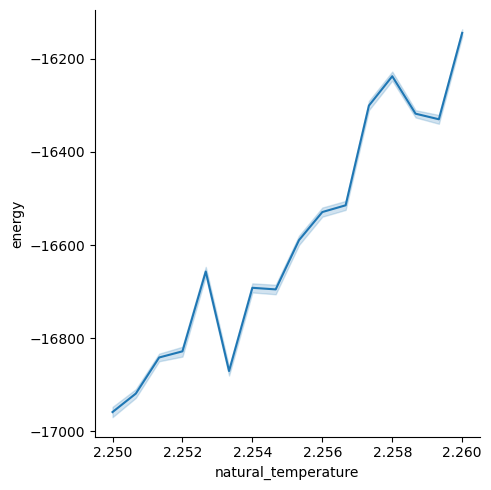

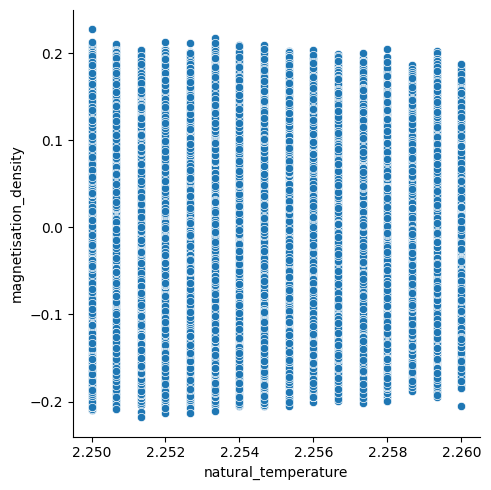

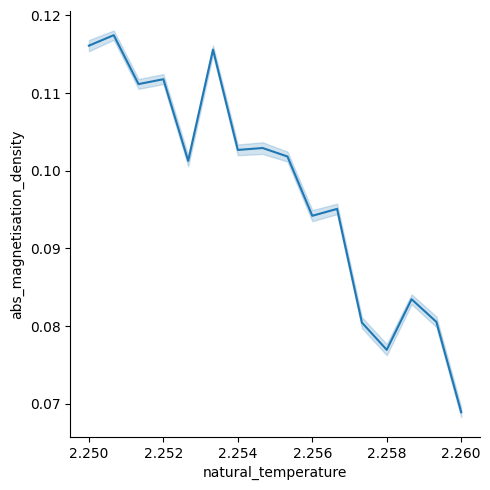

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

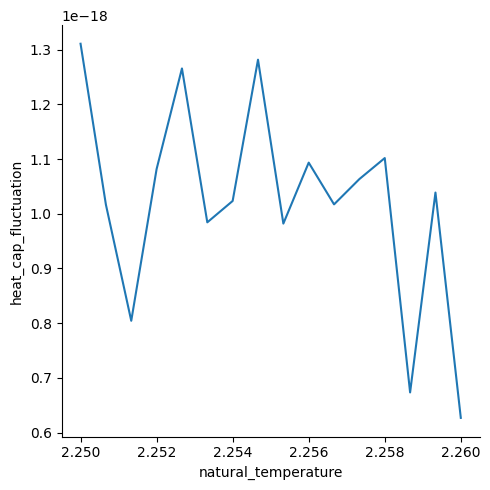

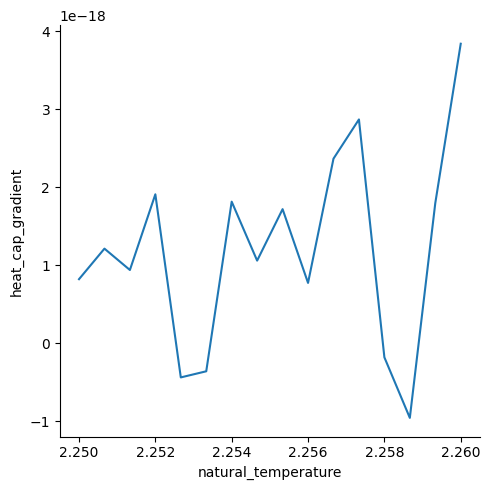

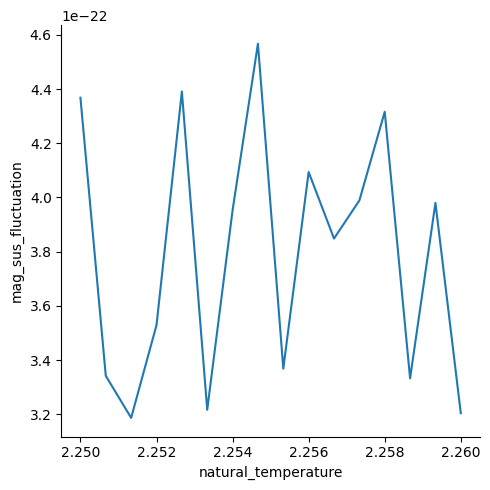

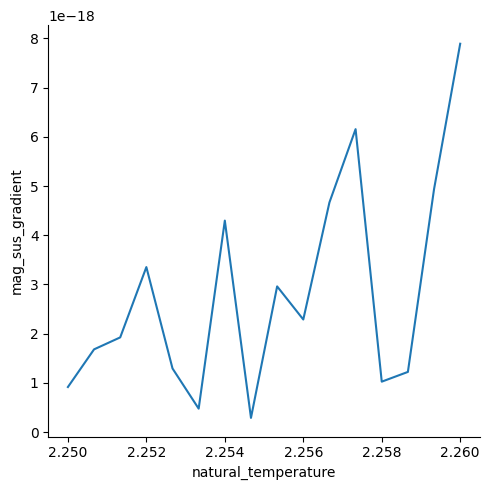

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

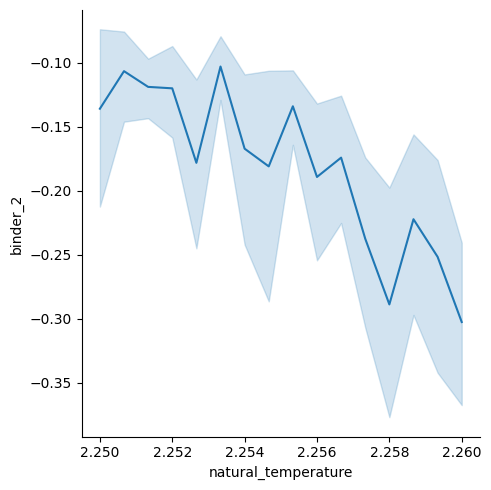

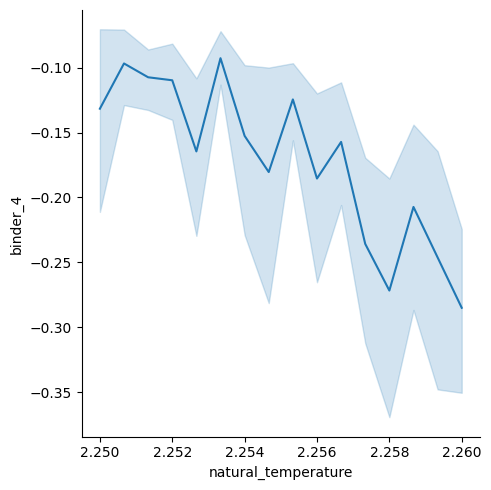

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )